METODOLOGÍA ARIMA - Seasonal ARIMA (SARIMA)

Análisis Exploratorio: Crear un modelo ARIMA requiere un análisis exploratorio exhaustivo. Este paso crítico sirve de brújula, guiando al analista hacia una comprensión detallada de la dinámica intrínseca de los datos. Antes de entrenar un modelo ARIMA a una serie temporal, es importante realizar un análisis exploratorio para determinar, como mínimo, lo siguiente:

Estacionariedad: la estacionariedad significa que las propiedades estadísticas (media, varianza...) permanecen constantes a lo largo del tiempo, por lo que las series temporales con tendencias o estacionalidad no son estacionarias. Dado que ARIMA presupone la estacionariedad de los datos, es esencial someterlos a pruebas rigurosas, como la prueba Dickey-Fuller aumentada, para evaluar que se cumple. Si se constata la no estacionariedad, las series deben diferenciarse hasta alcanzar la estacionariedad. Este análisis ayuda a determinar el valor óptimo del parámetro  d.

Análisis de autocorrelación: Graficar las funciones de autocorrelación y autocorrelación parcial (ACF y PACF) para identificar posibles relaciones de rezago (lags) entre los valores de la serie. Este análisis visual ayuda a determinar los términos autorregresivos (AR) y de media móvil (MA) adecuados (p y q) para el modelo ARIMA.

Descomposición estacional: en los casos donde se sospecha de estacionalidad, descomponer la serie en componentes de tendencia, estacionales y residuales utilizando técnicas como las medias móviles la descomposición estacional de series temporales (STL) puede revelar patrones ocultos y ayudar a identificar la estacionalidad. Este análisis ayuda a determinar los valores óptimos de los parámetros  P ,  D ,  Q  y  m.

Estos análisis exploratorios establecen la base para empezar a construir un modelo ARIMA efectivo que capture los patrones fundamentales y las asociaciones dentro de los datos.

Un modelo ARIMA se representa de la siguiente manera:

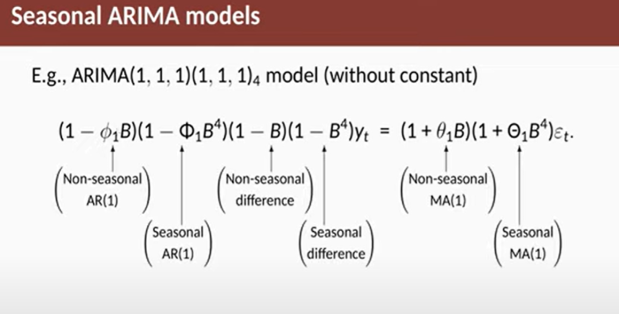

Donde:

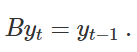

In [61]:
# Librerías estándar
import pandas as pd
from io import StringIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import contextlib
import re
from datetime import datetime
%matplotlib inline

In [62]:
# Librerías para SARIMA
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.2
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [63]:
import tabula
import pandas as pd

# Ruta del archivo Excel
ruta_archivo = 'C:/Users/User/Desktop/Santi/Trabajo CABA/Trabajo de predicción turismo receptivo CABA/Subido/Metodologías de estimación de la UNWTO - caso para ENTUR.xlsx'
df = pd.read_excel(ruta_archivo, sheet_name="Data")
df = df.rename(columns={'mes':'fecha', 'SUM de Turistas CABA':'receptivo'})
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m')
df = df.set_index('fecha')
df = df.asfreq('MS')
df.head()

,Tiempo,receptivo,Cambio i.a.,Unnamed: 4,"Dummy 1 si i.a. >0,5",Dummy 1 si x>desvest,Media móvil,Datos suavizados en pandemia con media móvil 6 meses,Decomposition,Turistas CABA sin efecto de pademia,Unnamed: 11,Unnamed: 12
fecha,,,,,,,,,,,,
2016-01-01,1,248684,NaN,NaN,0,0,NaN,248684.0,163554.059935,248684.0,NaN,97427.291255
2016-02-01,2,211731,NaN,NaN,0,0,NaN,211731.0,186385.153807,211731.0,NaN,NaN
2016-03-01,3,210862,NaN,NaN,0,0,NaN,210862.0,184615.176546,210862.0,NaN,NaN
2016-04-01,4,182419,NaN,NaN,0,0,NaN,182419.0,204700.838446,182419.0,NaN,NaN
2016-05-01,5,176403,NaN,NaN,0,0,NaN,176403.0,242583.704499,176403.0,NaN,NaN


In [64]:
df = df.drop(df.columns[2:8], axis=1)
df = df.drop(df.columns[0:1], axis=1)
df = df.drop(df.columns[2:7], axis=1)
df_1 = df.copy()
df_1

,receptivo,Decomposition
fecha,,
2016-01-01,248684,163554.059935
2016-02-01,211731,186385.153807
2016-03-01,210862,184615.176546
2016-04-01,182419,204700.838446
2016-05-01,176403,242583.704499
...,...,...
2024-03-01,278366,243716.687855
2024-04-01,224410,251820.891222
2024-05-01,182803,251384.777660


In [65]:
df = df.drop(df.columns[1:2], axis=1)
df

,receptivo
fecha,
2016-01-01,248684
2016-02-01,211731
2016-03-01,210862
2016-04-01,182419
2016-05-01,176403
...,...
2024-03-01,278366
2024-04-01,224410
2024-05-01,182803


Fechas prepandemia : 2016-01-01 00:00:00 --- 2020-02-01 00:00:00  (n=50)
Fechas postpandemia  : 2020-02-01 00:00:00 --- 2024-07-01 00:00:00  (n=54)


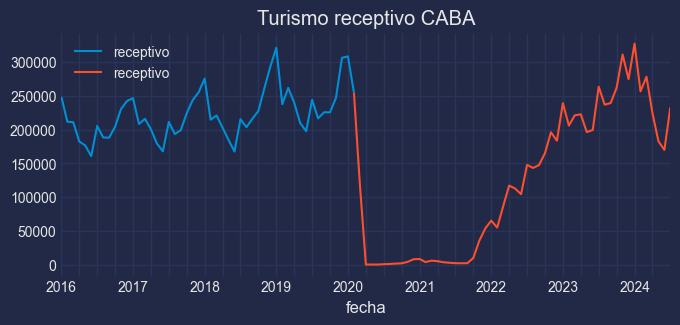

In [66]:
set_dark_theme()
fecha_pandemia = '2020-02-01'
print(
    f"Fechas prepandemia : {df.index.min()} --- {df.loc[:fecha_pandemia].index.max()}  "
    f"(n={len(df.loc[:fecha_pandemia])})"
)
print(
    f"Fechas postpandemia  : {df.loc[fecha_pandemia:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[fecha_pandemia:])})"
)
pre_pandamia = df.loc[:fecha_pandemia]
post_pandamia  = df.loc[fecha_pandemia:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
pre_pandamia.plot(ax=ax, label='Receptivo pre')
post_pandamia.plot(ax=ax, label='Receptivo post')
ax.set_title('Turismo receptivo CABA')
ax.legend();


- Estacionariedad: A nivel general, no se observa una clara tendencia, pero si recortamos los datos hasta 2020 nos encontramos con que existía una tendencia alcista hasta esa fecha que luego de la pandemia ya no es tan clara. De todas maneras, si tomamos todos los años es sospechable de que no existe una media constante y, menos aún, una varianza constante. Por esta razón se testeará con el test Dickey Fuller (DF), que es un test de hipótesis en donde la idea es testear si en la siguiente ecuación ρ = 1 (se centra en la presencia de una raíz unitaria):

![alt text](image.png)

Si se acepta que es así (Hipótesis nula aceptada), entonces no existe estacionariedad (no hay media y/o varianza constante), por lo que hay que diferenciar los datos para lograr estacionariedad.
Además se aplica la Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS), que se centra en intentar encontrar tendencias en la serie de datos (media que va creciendo o decreciendo en el tiempo), donde a diferencia del DF, rechazar la Hipotesis nula (H0) significa no estacionariedad. 

- Análisis de autocorrelación: Como dentro de la serie de datos se observa que puede existir, al menos hasta 2020, un componente autorregresivo de orden 1 (ρ = 1), es necesario determinar la dependencia temporal, esto es, saber si es solo una dependencia de la media y varianza respecto a un solo periodo pasado, o si esta media que parece ir creciendo hasta 2020 tiene dependencia de más de 1 lag. El análisis de autocorrelación utilizando la Función de autocorrelación (ACF) nos indicará cuántos lags componen la media del modelo, dando como resultado cuántos lags de relación hay entre el valor actual de la media y los pasados, si por ejemplo el ACF nos muestra una caída después de un segundo lag, esto sugeriría que en nuestro modelo ARIMA tenemos que incluír un componente MA (la parte "MA" de ARI"MA") de orden 2, MA(2).
Lo mismo ocurre para la Función de autocorrelación parcial (PACF), pero esta ocación es para la parte autorregresiva AR().
IMPORTANTE: es necesario que la serie sea estacional antes de observar la autocorrlación, sino solo se observarán los componentes estacional y no se podrán ver los componentes no estacional como la AR() o la MA().

- Descomposición estacional: Se puede notar un componente de estacionalidad, donde se cree que será necesaria una descomposición estacional por la dependencia de las fechas-meses que tiene la serie.


Remarcar, por si se presta a confusión que Estacionariedad es un concepto diferente que el de Estacionalidad, uno se centra en si existe constancia en la variación y media general de los datos, mientras que el otro (Estacionalidad) se centra en ver los movimientos de los datos dentro de un intervalo (1 año - 1 mes - 1 semana - etc.), en donde generalmente se tiende a verificar que dentro de los 12 meses del año existen patrones que se repiten año a año (verano con mayor turismo, etc.).


## Test de Estacionariedad
Entonces, primero queremos ver si la serie tiene componente no estacionales (estacionariedad), para esto, corremos el test Dickey Fuller a nivel general

In [67]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['receptivo'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.517962
p-value: 0.111165


In [68]:
print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df)
kpss_result = kpss(df)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -2.517961689965221, p-value: 0.11116499148866665
KPSS Statistic: 0.31818883550641414, p-value: 0.1


C:\Users\User\AppData\Local\Temp\ipykernel_8456\2160708070.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df)


No es posible rechazar el test de Dickey Fuller, pero no se rechaza el KPSS (p-value > 0.1, KPSS tiene el problema que no te muestra el p-value total si no es menor a 0.1, pero nos alcanza para no poder rechazar la H0). Se procederá a diferenciar la serie para lograr estacionalidad con el test DF.

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -2.517961689965221, p-value: 0.11116499148866665
KPSS Statistic: 0.31818883550641414, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -1.7683580034297786, p-value: 0.3962803202321915
KPSS Statistic: 0.10994544828103395, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -7.349856526434901, p-value: 1.0126713087200057e-10
KPSS Statistic: 0.04422925453975699, p-value: 0.1


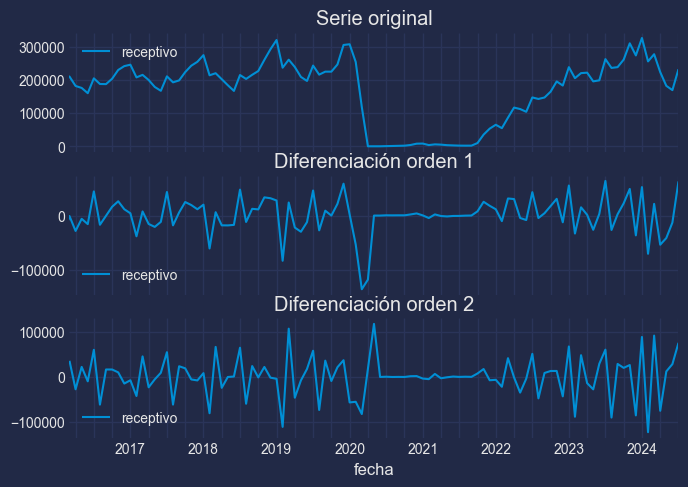

In [69]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = df.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df)
kpss_result = kpss(df)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(df.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(df.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
df.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

Diferenciando la serie 2 veces (d = 2) se logra estacionalizar la serie, por lo que ARIMA tendrá que tener un componente de integración 2.

## Test de Autocorrelación y Test para Descomposición estacional

En este punto es casi necesaria la combinación entre descomposición estacional y autocorrelación por las funciones de autocorrelación

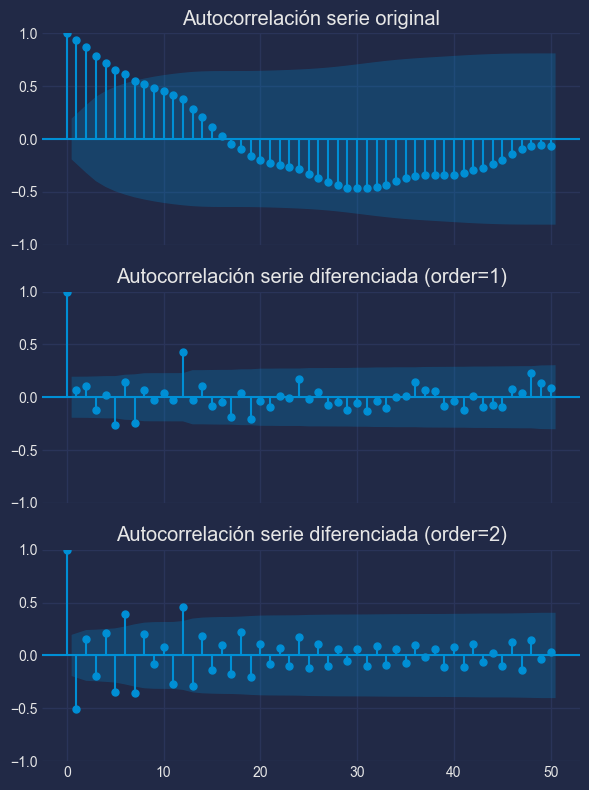

In [70]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Grafico de autocorrelación para la serie original y las series diferenciadas
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

# Autocorrelación de la serie original
plot_acf(df, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')

# Autocorrelación de la serie diferenciada de primer orden
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)')

# Autocorrelación de la serie diferenciada de segundo orden
plot_acf(datos_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Autocorrelación serie diferenciada (order=2)')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


Después del primer periodo, la diff 2 cae fuerte, lo que puede indicar un MA(1)

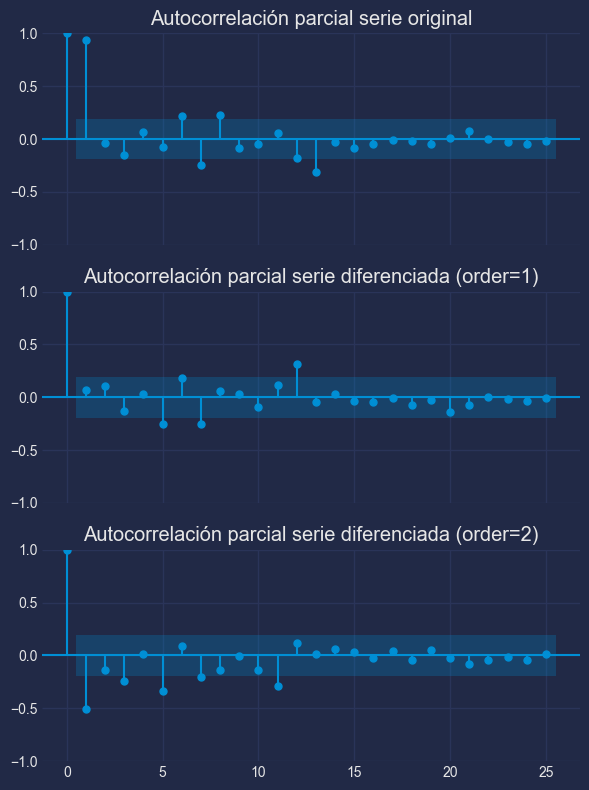

In [71]:
# Grafico de autocorrelación para la serie original y las series diferenciadas
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

# Autocorrelación de la serie original
plot_pacf(df, ax=axs[0], lags=25, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')

# Autocorrelación de la serie diferenciada de primer orden
plot_pacf(datos_diff_1, ax=axs[1], lags=25, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie diferenciada (order=1)')

# Autocorrelación de la serie diferenciada de segundo orden
plot_pacf(datos_diff_2, ax=axs[2], lags=25, alpha=0.05)
axs[2].set_title('Autocorrelación parcial serie diferenciada (order=2)')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


Se observa en la serie diferenciada de orden 2, que parece tener un componente autorregresivo de orden 3, AR(3) (no se da importancia a rechazos en t=5 o t=7 porque es posible que complejizar el modelo con órdenes superiores no mejore la estimación, de todas maneras esto podría ser testeado a través de del criterio de Akaike para la selección final del modelo, pero no se realizará en este trabajo).
Algo interesante a obsrevar, es que en la serie diferenciada 1 vez se observa un componente anual (12 meses) en la PACF respecto al componente estacional. Lo mismo sucede con la ACF. Esto sugiere que Q y P valen 1, D también vale 1 y S=12.

## Test para Descomposición estacional
La descomposición de series temporales consiste en descomponer la serie temporal original en sus componentes fundamentales: la tendencia, la estacionalidad y los residuos. Esta descomposición puede llevarse a cabo de manera aditiva o multiplicativa. Al combinar la descomposición de las series temporales con el análisis de la ACF y la PACF, se obtiene una descripción bastante completa con la que comprender la estructura subyacente de los datos y acotar el valor los parámetros ARIMA más apropiados.
Cabe remarcar que en este caso se utiliza la descomposición aditiva, que es la más común.

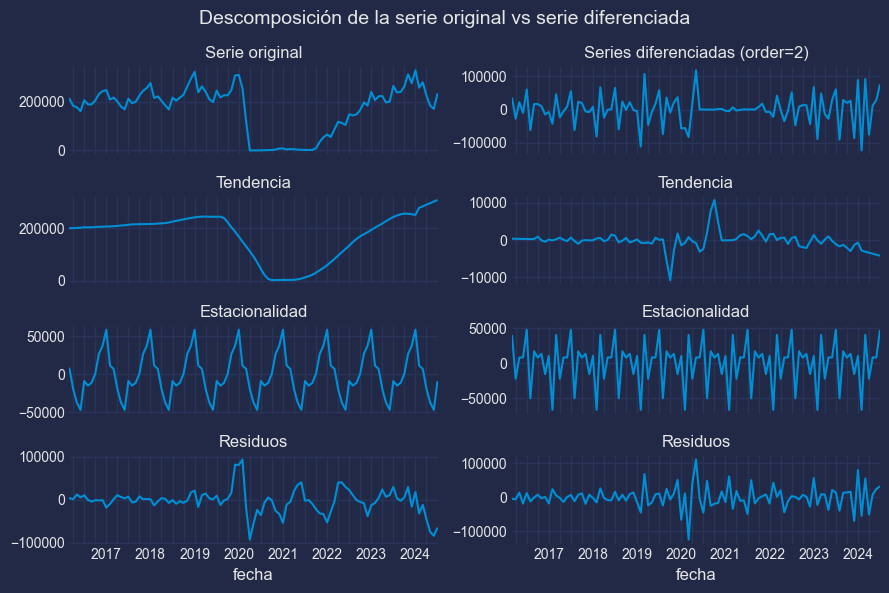

In [72]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(df, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_2, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=2)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

Los gráficos de Estacionalidad de la serie diferenciada muestran una clara estacionalidad cada 12 meses como es esperable, así que se aplicará dicha descomposición.
Además, parece haber un  componente tendencial negativo si no tomamos en cuenta el quiebre en 2020.

In [73]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_12 = df.diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -1.9517395748852924, p-value: 0.30812593389796183
KPSS Statistic: 0.3189400866135082, p-value: 0.1


Se encuentra que la diferenciación de 12 meses logra estacionalizar los datos, lo cual indica que a nuestro modelo ARIMA (1,2,3) si se aplicará el componente estiacional (S) para precisar la predicción: Modelo final: ARIMA (1,2,3) (1,1,1,12)

In [74]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = df, order = (1,2,3), seasonal_order = (1,1,1,12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            receptivo   No. Observations:                  103
Model:             SARIMAX(1, 2, 3)x(1, 1, [1], 12)   Log Likelihood               -1044.342
Date:                              Thu, 24 Oct 2024   AIC                           2102.683
Time:                                      12:51:51   BIC                           2120.104
Sample:                                  01-01-2016   HQIC                          2109.705
                                       - 07-01-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9734      0.159     -6.123      0.000      -1.285      -0.662
ma.L1          0.2488      0.160      1.553      0.120      -0.065       0.563
ma.L2         -0.8802      0.141     -6.226      0.000      -1.157      -0.603
ma.L3         -0.2702      0.161     -1.675      0.094      -0.586       0.046
ar.S.L12       0.3366      0.212      1.590      0.112      -0.078       0.751
ma.S.L12      -0.8472      0.275     -3.076      0.002      -1.387      -0.307
sigma2       1.21e+09   3.93e-10   3.08e+18      0.000    1.21e+09    1.21e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               241.21
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                            -1.42
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.27e+33. Standard errors may be unstable.
"""

In [75]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(df)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(12))

2024-08-01    207852.982073
2024-09-01    218272.267216
2024-10-01    224822.030096
2024-11-01    266662.956440
2024-12-01    245208.069585
2025-01-01    295634.047374
2025-02-01    234812.544759
2025-03-01    249629.582146
2025-04-01    206354.325011
2025-05-01    185229.159723
2025-06-01    167925.604890
2025-07-01    220959.468059
Freq: MS, Name: predicciones_statsmodels, dtype: float64

In [76]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order = (1,2,3), seasonal_order = (1,1,1,12))
modelo.fit(y=df)
modelo.summary()

c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  103
Model:             SARIMAX(1, 2, 3)x(1, 1, [1], 12)   Log Likelihood               -1047.542
Date:                              Thu, 24 Oct 2024   AIC                           2111.084
Time:                                      12:51:52   BIC                           2130.993
Sample:                                  01-01-2016   HQIC                          2119.109
                                       - 07-01-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1034.6860    798.410     -1.296      0.195   -2599.541     530.169
ar.L1         -0.9787      0.099     -9.884      0.000      -1.173      -0.785
ma.L1          0.3745      0.143      2.616      0.009       0.094       0.655
ma.L2         -0.7216      0.102     -7.052      0.000      -0.922      -0.521
ma.L3         -0.2299      0.176     -1.304      0.192      -0.575       0.116
ar.S.L12       0.2926      0.219      1.336      0.181      -0.137       0.722
ma.S.L12      -0.8010      0.259     -3.087      0.002      -1.309      -0.292
sigma2       1.21e+09      0.001   2.39e+12      0.000    1.21e+09    1.21e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               187.95
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -1.16
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+28. Standard errors may be unstable.
"""

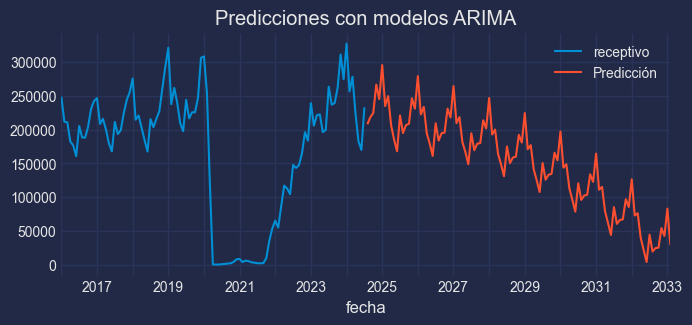

In [77]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
df.plot(ax=ax, label='Turismo Receptivo')
predicciones_statsmodels.plot(ax=ax, label='Predicción')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (1,2,3), seasonal_order = (1,1,1,12))
results = model.fit()


c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [79]:
# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # Obtiene intervalos de confianza

In [80]:
# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})
predicciones_df

,predicted_mean,conf_int_lower,conf_int_upper,std_error
2024-08-01,207852.982073,1.392583e+05,2.764477e+05,3.499731e+04
2024-09-01,218272.267216,1.069478e+05,3.295967e+05,5.679820e+04
2024-10-01,224822.030096,7.866502e+04,3.709790e+05,7.456990e+04
2024-11-01,266662.956440,9.235275e+04,4.409732e+05,8.893378e+04
2024-12-01,245208.069585,4.328880e+04,4.471273e+05,1.030200e+05
...,...,...,...,...
2032-10-01,25063.874441,-5.765082e+06,5.815210e+06,2.954156e+06
2032-11-01,54039.220800,-5.832867e+06,5.940945e+06,3.003523e+06
2032-12-01,42369.302512,-5.942624e+06,6.027363e+06,3.053568e+06
2033-01-01,82849.202524,-6.000173e+06,6.165872e+06,3.103583e+06


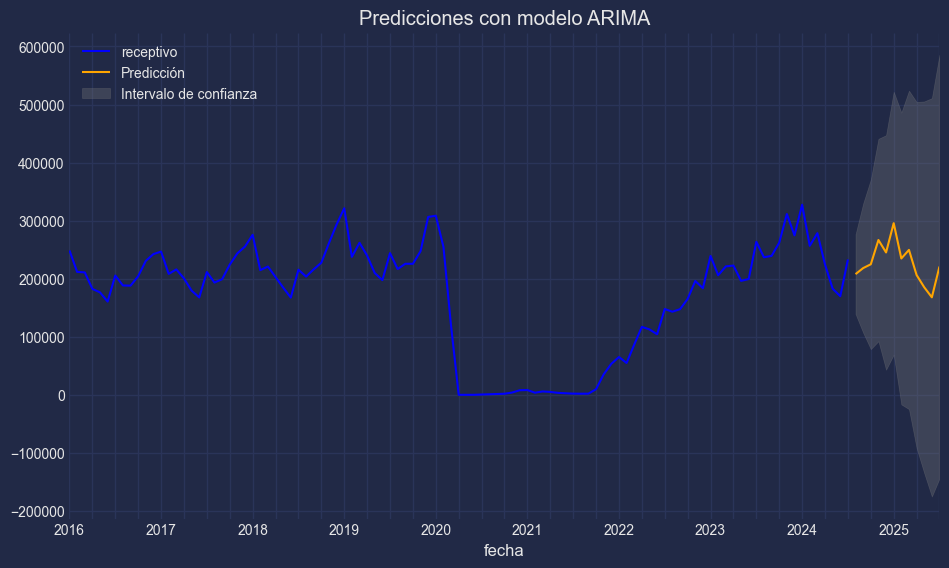

In [81]:
import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(12) # analizo los próximos 12 meses

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()


#### Analizo qué tan bien estimo el pasado a través del error de predicción medio (MSE)

Fechas prepandemia : 2016-01-01 00:00:00 --- 2024-06-01 00:00:00  (n=102)
Fechas postpandemia  : 2024-06-01 00:00:00 --- 2024-07-01 00:00:00  (n=2)


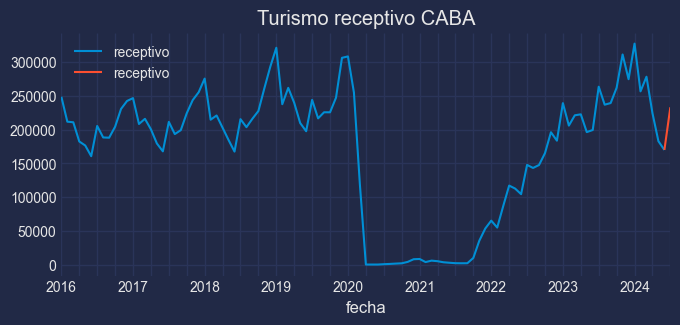

In [82]:
fecha_final = '2024-06-01'
print(
    f"Fechas prepandemia : {df.index.min()} --- {df.loc[:fecha_final].index.max()}  "
    f"(n={len(df.loc[:fecha_final])})"
)
print(
    f"Fechas postpandemia  : {df.loc[fecha_final:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[fecha_final:])})"
)
pre_data = df.loc[:fecha_final]
post_data  = df.loc[fecha_final:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
pre_data.plot(ax=ax, label='Receptivo pre')
post_data.plot(ax=ax, label='Receptivo post')
ax.set_title('Turismo receptivo CABA')
ax.legend();

Fechas entrenamiento : 2016-01-01 00:00:00 --- 2022-06-01 00:00:00  (n=78)
Fechas validacion    : 2022-06-01 00:00:00 --- 2023-06-01 00:00:00  (n=13)
Fechas test          : 2023-06-01 00:00:00 --- 2024-06-01 00:00:00  (n=13)


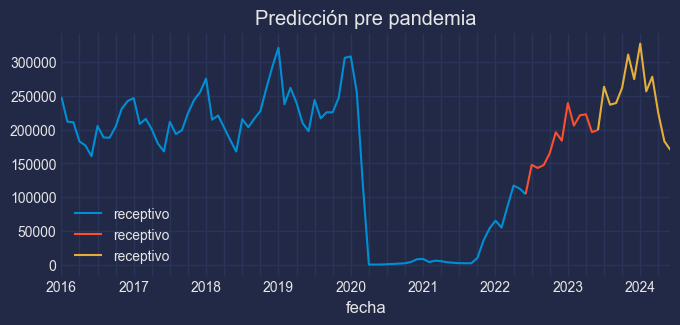

In [83]:
# Train-validation-test
# ======================================================================================
fin_train = '2022-06-01'
fin_val = '2023-06-01'
print(
    f"Fechas entrenamiento : {pre_data.index.min()} --- {pre_data.loc[:fin_train].index.max()}  "
    f"(n={len(pre_data.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {pre_data.loc[fin_train:].index.min()} --- {pre_data.loc[:fin_val].index.max()}  "
    f"(n={len(pre_data.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {pre_data.loc[fin_val:].index.min()} --- {pre_data.index.max()}  "
    f"(n={len(pre_data.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
pre_data.loc[:fin_train].plot(ax=ax, label='entrenamiento')
pre_data.loc[fin_train:fin_val].plot(ax=ax, label='validación')
pre_data.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Predicción pre pandemia')
ax.legend();

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
yt = df.copy()

# Asegurarse de que y es una Serie
if isinstance(df, pd.DataFrame):
    yt = yt.squeeze()  # Convierte DataFrame de una sola columna a Series


modelo = SARIMAX(endog = yt, order = (1,2,3), seasonal_order = (1,1,1,12))
modelo_res_1 = modelo.fit(disp=0)
modelo_res_1.summary()
forecast = modelo_res_1.get_forecast(steps=len(yt)).predicted_mean
forecast.name = 'predicciones_statsmodels'
display(yt.tail(12))
display(forecast.head(-12))
display(forecast.head(4))

c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


fecha
2023-08-01    236928
2023-09-01    239336
2023-10-01    262043
2023-11-01    311342
2023-12-01    274711
2024-01-01    327427
2024-02-01    256687
2024-03-01    278366
2024-04-01    224410
2024-05-01    182803
2024-06-01    169847
2024-07-01    233105
Freq: MS, Name: receptivo, dtype: int64

2024-08-01    207852.982073
2024-09-01    218272.267216
2024-10-01    224822.030096
2024-11-01    266662.956440
2024-12-01    245208.069585
                  ...      
2031-10-01     66997.383710
2031-11-01     96652.021916
2031-12-01     85220.937049
2032-01-01    126367.643685
2032-02-01     72625.113212
Freq: MS, Name: predicciones_statsmodels, Length: 91, dtype: float64

2024-08-01    207852.982073
2024-09-01    218272.267216
2024-10-01    224822.030096
2024-11-01    266662.956440
Freq: MS, Name: predicciones_statsmodels, dtype: float64

c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


fecha
2023-08-01    236928
2023-09-01    239336
2023-10-01    262043
2023-11-01    311342
2023-12-01    274711
2024-01-01    327427
2024-02-01    256687
2024-03-01    278366
2024-04-01    224410
2024-05-01    182803
2024-06-01    169847
2024-07-01    233105
Freq: MS, Name: receptivo, dtype: int64

2024-08-01    207852.982073
2024-09-01    218272.267216
2024-10-01    224822.030096
2024-11-01    266662.956440
2024-12-01    245208.069585
                  ...      
2031-10-01     66997.383710
2031-11-01     96652.021916
2031-12-01     85220.937049
2032-01-01    126367.643685
2032-02-01     72625.113212
Freq: MS, Name: predicciones_statsmodels, Length: 91, dtype: float64

2024-08-01    207852.982073
2024-09-01    218272.267216
2024-10-01    224822.030096
2024-11-01    266662.956440
Freq: MS, Name: predicciones_statsmodels, dtype: float64

              Real       Ajustado
fecha                            
2016-01-01  248684       0.000000
2016-02-01  211731  408198.883030
2016-03-01  210862  238358.229921
2016-04-01  182419  235312.131690
2016-05-01  176403  215222.963658
...            ...            ...
2024-03-01  278366  258630.397289
2024-04-01  224410  267427.419814
2024-05-01  182803  204777.710590
2024-06-01  169847  163139.031618
2024-07-01  233105  224046.163623

[103 rows x 2 columns]
Variable Original:  fecha
2016-01-01    248684
2016-02-01    211731
2016-03-01    210862
2016-04-01    182419
2016-05-01    176403
               ...  
2024-03-01    278366
2024-04-01    224410
2024-05-01    182803
2024-06-01    169847
2024-07-01    233105
Freq: MS, Name: receptivo, Length: 103, dtype: int64
Predicción:  2024-08-01    207852.982073
2024-09-01    218272.267216
2024-10-01    224822.030096
2024-11-01    266662.956440
2024-12-01    245208.069585
                  ...      
2032-10-01     25063.874441
2032-11-01     

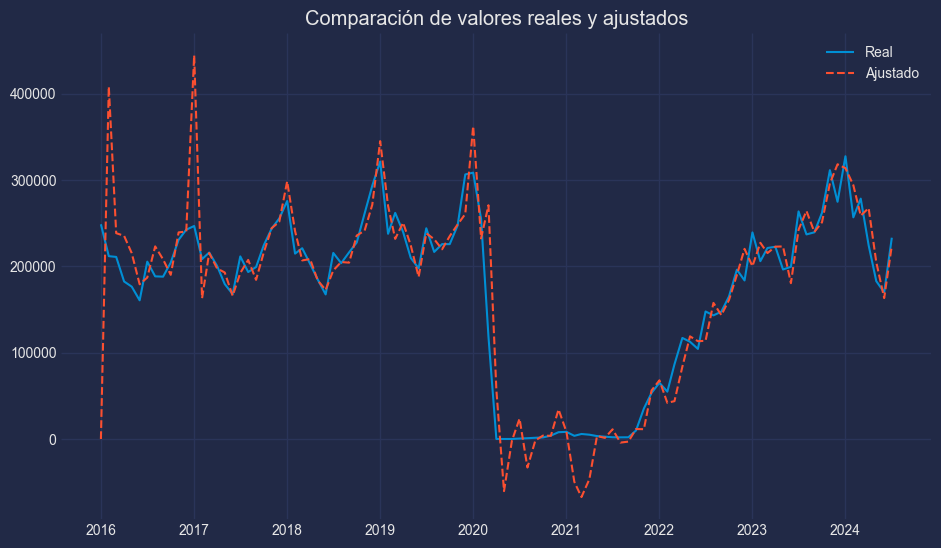

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

yt = df.copy()

# Asegurarse de que y es una Serie
if isinstance(df, pd.DataFrame):
    yt = yt.squeeze()  # Convierte DataFrame de una sola columna a Series


modelo = SARIMAX(endog = yt, order = (1,2,3), seasonal_order = (1,1,1,12))
modelo_res_1 = modelo.fit(disp=0)
modelo_res_1.summary()
fitted_values = modelo_res_1.fittedvalues
forecast = modelo_res_1.get_forecast(steps=len(yt)).predicted_mean
forecast.name = 'predicciones_statsmodels'
display(yt.tail(12))
display(forecast.head(-12))
display(forecast.head(4))

# Crear un DataFrame que compare los valores reales y ajustados
comparison = pd.DataFrame({'Real': df['receptivo'], 'Ajustado': fitted_values})

# Mostrar los primeros valores para verificar
print(comparison)

# 3. Calcular el error cuadrático medio (MSE)
print('Variable Original: ', yt)
print('Predicción: ', forecast)

import matplotlib.pyplot as plt

# Graficar valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(comparison.index, comparison['Real'], label='Real')
plt.plot(comparison.index, fitted_values, label='Ajustado', linestyle='--')
plt.title('Comparación de valores reales y ajustados')
plt.legend()
plt.show()


#### Con una grilla se puede obtener otra estimación

Fechas prepandemia : 2016-01-01 00:00:00 --- 2024-06-01 00:00:00  (n=102)
Fechas postpandemia  : 2024-06-01 00:00:00 --- 2024-07-01 00:00:00  (n=2)
Fechas entrenamiento : 2016-01-01 00:00:00 --- 2022-06-01 00:00:00  (n=78)
Fechas validacion    : 2022-06-01 00:00:00 --- 2023-06-01 00:00:00  (n=13)
Fechas test          : 2023-06-01 00:00:00 --- 2024-06-01 00:00:00  (n=13)


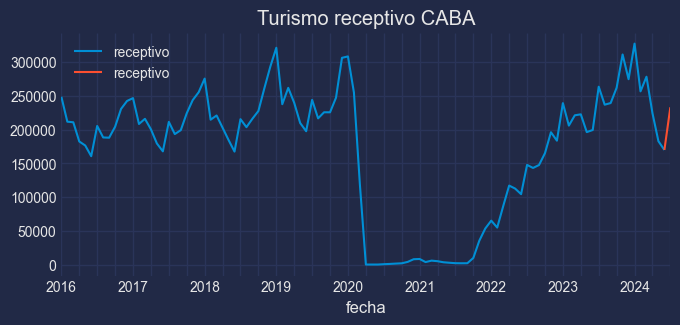

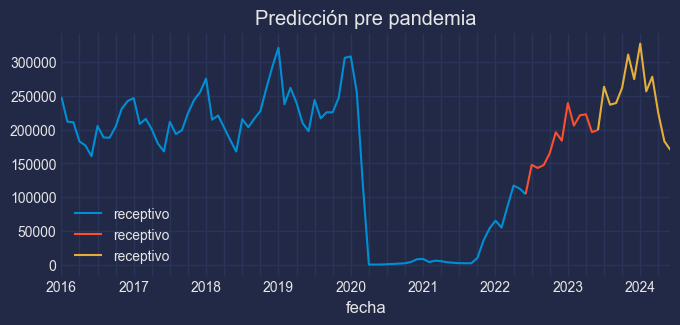

In [86]:
fecha_final = '2024-06-01'
print(
    f"Fechas prepandemia : {df.index.min()} --- {df.loc[:fecha_final].index.max()}  "
    f"(n={len(df.loc[:fecha_final])})"
)
print(
    f"Fechas postpandemia  : {df.loc[fecha_final:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[fecha_final:])})"
)
pre_data = df.loc[:fecha_final]
post_data  = df.loc[fecha_final:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
pre_data.plot(ax=ax, label='Receptivo pre')
post_data.plot(ax=ax, label='Receptivo post')
ax.set_title('Turismo receptivo CABA')
ax.legend();

# Train-validation-test
# ======================================================================================
fin_train = '2022-06-01'
fin_val = '2023-06-01'
print(
    f"Fechas entrenamiento : {pre_data.index.min()} --- {pre_data.loc[:fin_train].index.max()}  "
    f"(n={len(pre_data.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {pre_data.loc[fin_train:].index.min()} --- {pre_data.loc[:fin_val].index.max()}  "
    f"(n={len(pre_data.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {pre_data.loc[fin_val:].index.min()} --- {pre_data.index.max()}  "
    f"(n={len(pre_data.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
pre_data.loc[:fin_train].plot(ax=ax, label='entrenamiento')
pre_data.loc[fin_train:fin_val].plot(ax=ax, label='validación')
pre_data.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Predicción pre pandemia')
ax.legend();

c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


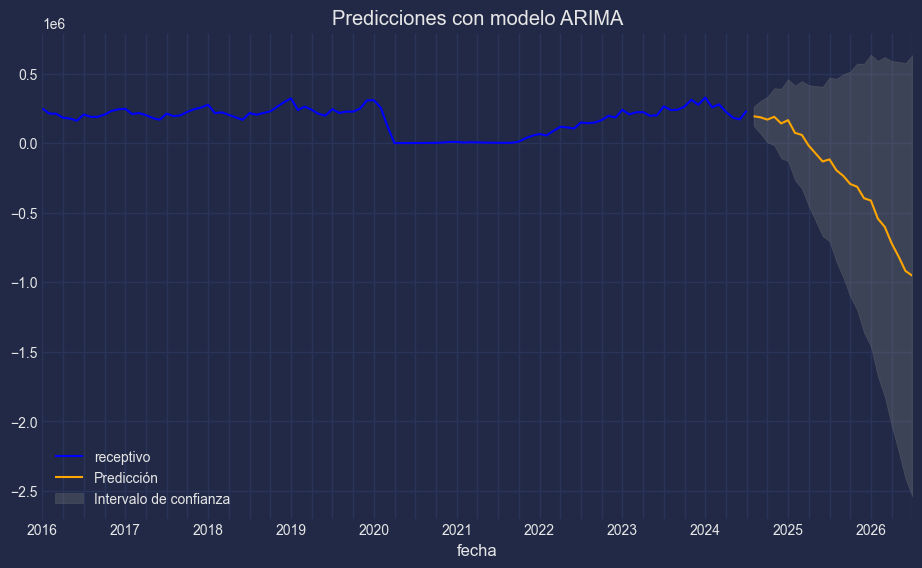

2024-08-01    192560.708441
2024-09-01    185173.093990
2024-10-01    168750.034893
2024-11-01    188847.820096
2024-12-01    140876.787580
2025-01-01    164808.805512
2025-02-01     73351.035298
2025-03-01     58507.976456
2025-04-01    -19395.566200
2025-05-01    -75098.102863
2025-06-01   -132115.721749
2025-07-01   -117301.367176
Freq: MS, Name: predicted_mean, dtype: float64

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (1, 2, 3), seasonal_order = (1, 1, 1, 12), trend = 'c')
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(24)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()
predicciones_df_head['predicted_mean'].head(12)

In [88]:
################################################################################################
# Verifico datos

fin_train = '2023-06-01'
fin_test = '2024-06-01'

datos_train = df.loc[:fin_train]
datos_test  = df.loc[:fin_test]

# Asegurarse de que y es una Serie
if isinstance(datos_train, pd.DataFrame):
    y_train = datos_train.squeeze()  # Convierte DataFrame de una sola columna a Series
# Asegurarse de que y es una Serie
if isinstance(datos_test, pd.DataFrame):
    y_test = datos_test.squeeze()  # Convierte DataFrame de una sola columna a Series

print(y_train.isnull().sum())
print(y_test.isnull().sum())

df.index = pd.to_datetime(df.index)

# ==============================================================================

# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1),(2, 1, 1), (2, 1, 2), (2, 2, 1), (2, 2, 2), (1, 2, 3)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'c']
}


resultados_grid_MAE_predict = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = y_test,
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(y_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )


resultados_grid_MAPE = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = y_test,
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_percentage_error',
                        initial_train_size    = len(y_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )


0
0
Number of models compared: 54.


params grid:  85%|████████▌ | 46/54 [00:12<00:02,  3.61it/s]


KeyboardInterrupt: 

In [30]:
resultados_grid_MAE_predict.head(10)

,params,mean_absolute_error,order,seasonal_order,trend
51,"{'order': (1, 2, 3), 'seasonal_order': (0, 1, ...",26365.533160,"(1, 2, 3)","(0, 1, 0, 12)",c
41,"{'order': (2, 2, 1), 'seasonal_order': (1, 1, ...",27478.481757,"(2, 2, 1)","(1, 1, 1, 12)",c
28,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",29587.974892,"(2, 1, 1)","(1, 1, 1, 12)",None
22,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",29593.642847,"(1, 1, 1)","(1, 1, 1, 12)",None
10,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",29596.320636,"(0, 1, 1)","(1, 1, 1, 12)",None
16,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",29622.581294,"(1, 1, 0)","(1, 1, 1, 12)",None
34,"{'order': (2, 1, 2), 'seasonal_order': (1, 1, ...",29642.255902,"(2, 1, 2)","(1, 1, 1, 12)",None
47,"{'order': (2, 2, 2), 'seasonal_order': (1, 1, ...",29942.082122,"(2, 2, 2)","(1, 1, 1, 12)",c
4,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",30715.096115,"(0, 1, 0)","(1, 1, 1, 12)",None
53,"{'order': (1, 2, 3), 'seasonal_order': (1, 1, ...",31059.948610,"(1, 2, 3)","(1, 1, 1, 12)",c


In [31]:
resultados_grid_MAPE.head(10)

,params,mean_absolute_percentage_error,order,seasonal_order,trend
53,"{'order': (1, 2, 3), 'seasonal_order': (1, 1, ...",0.116846,"(1, 2, 3)","(1, 1, 1, 12)",c
51,"{'order': (1, 2, 3), 'seasonal_order': (0, 1, ...",0.125107,"(1, 2, 3)","(0, 1, 0, 12)",c
41,"{'order': (2, 2, 1), 'seasonal_order': (1, 1, ...",0.128462,"(2, 2, 1)","(1, 1, 1, 12)",c
16,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",0.136658,"(1, 1, 0)","(1, 1, 1, 12)",None
22,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",0.136939,"(1, 1, 1)","(1, 1, 1, 12)",None
28,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",0.136965,"(2, 1, 1)","(1, 1, 1, 12)",None
10,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",0.136967,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (2, 1, 2), 'seasonal_order': (1, 1, ...",0.137276,"(2, 1, 2)","(1, 1, 1, 12)",None
47,"{'order': (2, 2, 2), 'seasonal_order': (1, 1, ...",0.140856,"(2, 2, 2)","(1, 1, 1, 12)",c
4,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",0.141050,"(0, 1, 0)","(1, 1, 1, 12)",None


c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


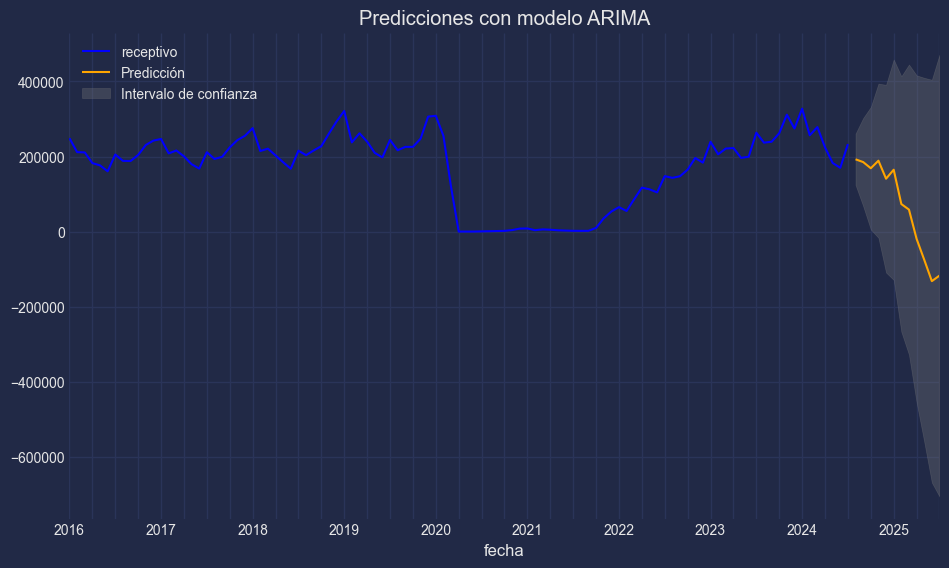

              Real       Ajustado
fecha                            
2016-01-01  248684    -739.186221
2016-02-01  211731  407764.052814
2016-03-01  210862  239727.291184
2016-04-01  182419  228762.378313
2016-05-01  176403  212627.612700
...            ...            ...
2024-03-01  278366  245363.638750
2024-04-01  224410  254641.216888
2024-05-01  182803  190392.846306
2024-06-01  169847  142937.401361
2024-07-01  233105  209354.552567

[103 rows x 2 columns]


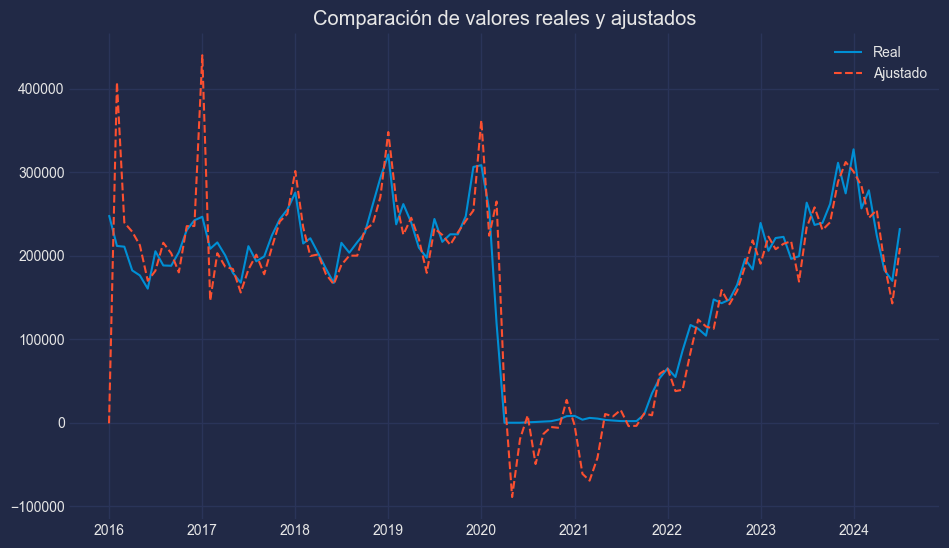

2024-08-01    192560.708441
2024-09-01    185173.093990
2024-10-01    168750.034893
2024-11-01    188847.820096
2024-12-01    140876.787580
2025-01-01    164808.805512
2025-02-01     73351.035298
2025-03-01     58507.976456
2025-04-01    -19395.566200
2025-05-01    -75098.102863
2025-06-01   -132115.721749
2025-07-01   -117301.367176
Freq: MS, Name: predicted_mean, dtype: float64

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (1, 2, 3), seasonal_order = (1, 1, 1, 12), trend = 'c')
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(12)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()

# Observo el ajuste dentro de los datos

fitted_values = results.fittedvalues
# Crear un DataFrame que compare los valores reales y ajustados
comparison_1 = pd.DataFrame({'Real': df['receptivo'], 'Ajustado': fitted_values})

# Mostrar los primeros valores para verificar
print(comparison_1)

# Graficar valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(comparison_1.index, comparison_1['Real'], label='Real')
plt.plot(comparison_1.index, fitted_values, label='Ajustado', linestyle='--')
plt.title('Comparación de valores reales y ajustados')
plt.legend()
plt.show()
predicciones_df_head['predicted_mean'].head(12)

c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


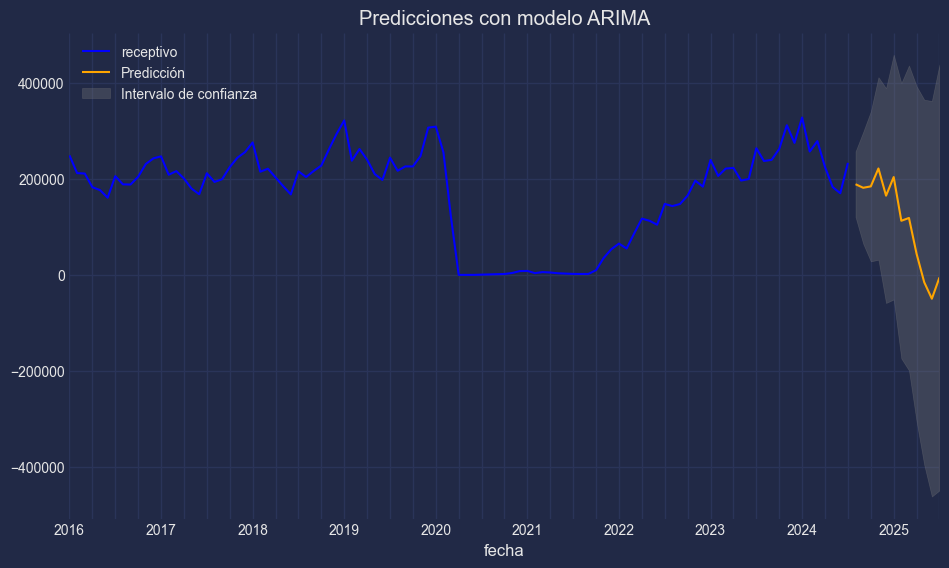

              Real       Ajustado
fecha                            
2016-01-01  248684    -550.391350
2016-02-01  211731  414006.015674
2016-03-01  210862  230588.251609
2016-04-01  182419  226390.634553
2016-05-01  176403  217691.607295
...            ...            ...
2024-03-01  278366  256780.951099
2024-04-01  224410  272434.694382
2024-05-01  182803  175371.316244
2024-06-01  169847  167202.156481
2024-07-01  233105  226565.794970

[103 rows x 2 columns]


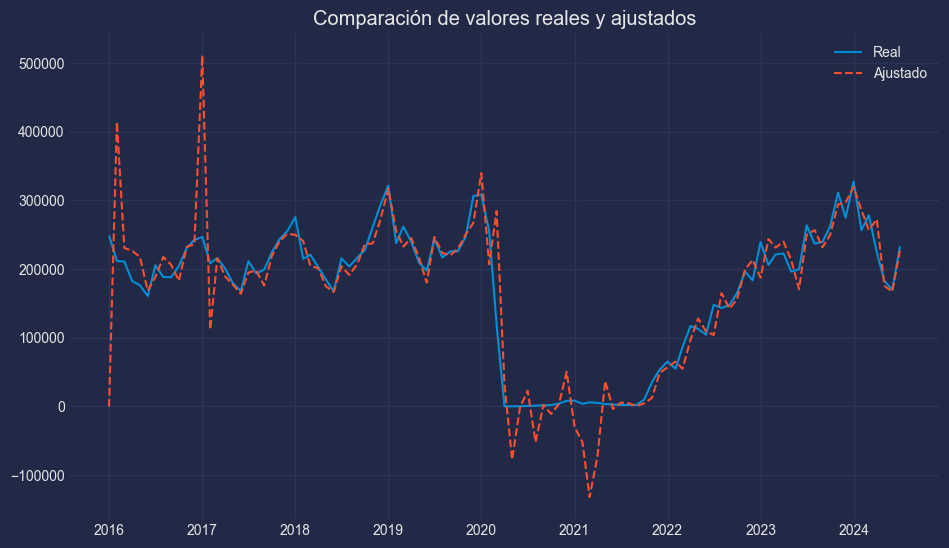

            conf_int_lower  conf_int_upper
2024-08-01    1.204663e+05    2.567984e+05
2024-09-01    6.512772e+04    2.973612e+05
2024-10-01    2.810754e+04    3.401512e+05
2024-11-01    3.152238e+04    4.112658e+05
2024-12-01   -5.853479e+04    3.882172e+05
...                    ...             ...
2032-10-01   -3.407757e+07    3.531061e+06
2032-11-01   -3.481829e+07    3.617923e+06
2032-12-01   -3.566385e+07    3.609147e+06
2033-01-01   -3.642005e+07    3.696267e+06
2033-02-01   -3.731625e+07    3.652071e+06

[103 rows x 2 columns]


2024-08-01    188632.368637
2024-09-01    181244.475609
2024-10-01    184129.351869
2024-11-01    221394.082013
2024-12-01    164841.199171
2025-01-01    203541.297972
2025-02-01    112553.733370
2025-03-01    118434.001003
2025-04-01     43729.820839
2025-05-01    -15304.810059
2025-06-01    -49645.058491
2025-07-01     -5324.396592
Freq: MS, Name: predicted_mean, dtype: float64

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
		
# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (1, 2, 3), seasonal_order = (0, 1, 0, 12), trend = 'c')
results = model.fit()


# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # Obtiene intervalos de confianza	(se puede modificar para poner otro nivel de confianza)

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)


# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(12)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()

# Observo el ajuste dentro de los datos

fitted_values = results.fittedvalues
# Crear un DataFrame que compare los valores reales y ajustados
comparison_1 = pd.DataFrame({'Real': df['receptivo'], 'Ajustado': fitted_values})

# Mostrar los primeros valores para verificar
print(comparison_1)

# Graficar valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(comparison_1.index, comparison_1['Real'], label='Real')
plt.plot(comparison_1.index, fitted_values, label='Ajustado', linestyle='--')
plt.title('Comparación de valores reales y ajustados')
plt.legend()
plt.show()
print(predicciones_df[['conf_int_lower', 'conf_int_upper']])
predicciones_df_head['predicted_mean'].head(12)


              Real       Ajustado
fecha                            
2016-01-01  248684    -316.100000
2016-02-01  211731  248367.900000
2016-03-01  210862  211414.900000
2016-04-01  182419  210545.900000
2016-05-01  176403  182102.900000
2016-06-01  160586  176086.900000
2016-07-01  205385  160269.900000
2016-08-01  188354  205068.900000
2016-09-01  187990  188037.900000
2016-10-01  204246  187673.900000
2016-11-01  230713  203929.900000
2016-12-01  242419  230396.900000
2017-01-01  246675  490565.963916
2017-02-01  208332  209405.900000
              Real  Ajustado
fecha                       
2024-06-01  169847  185625.9
2024-07-01  233105  233666.9


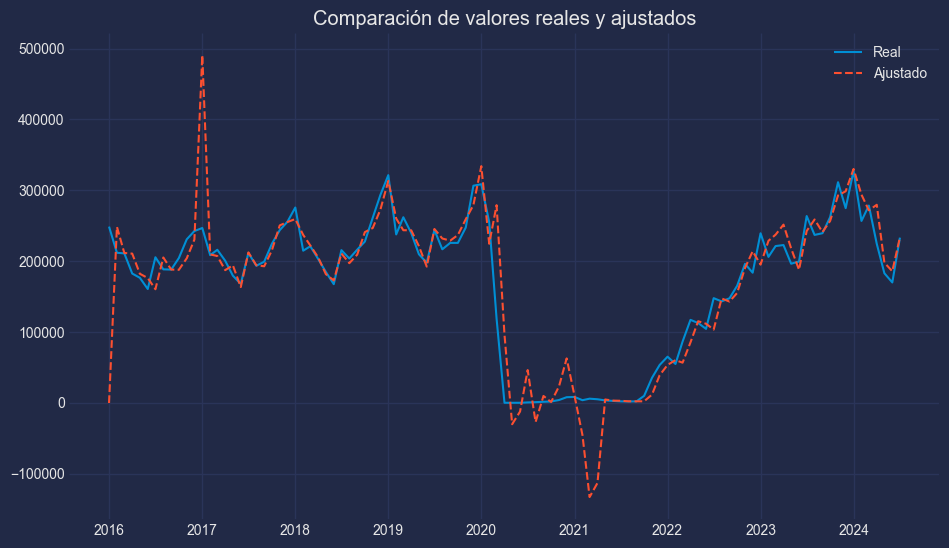

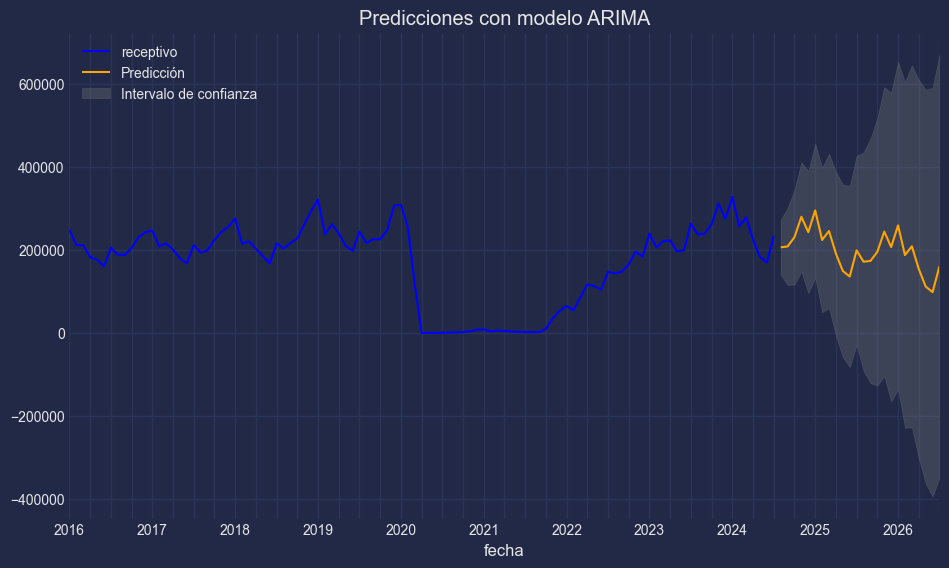

2024-08-01    206153.9
2024-09-01    208245.8
2024-10-01    230636.7
2024-11-01    279619.6
2024-12-01    242672.5
2025-01-01    295072.4
2025-02-01    224016.3
2025-03-01    245379.2
2025-04-01    191107.1
2025-05-01    149184.0
2025-06-01    135911.9
2025-07-01    198853.8
Freq: MS, Name: predicted_mean, dtype: float64

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (0, 1, 0), seasonal_order = (0, 1, 0, 12), trend = 'c')
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Observo el ajuste dentro de los datos

fitted_values = results.fittedvalues
# Crear un DataFrame que compare los valores reales y ajustados
comparison_1 = pd.DataFrame({'Real': df['receptivo'], 'Ajustado': fitted_values})

# Mostrar los primeros valores para verificar
print(comparison_1.head(14))
print(comparison_1.tail(2))

# Graficar valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(comparison_1.index, comparison_1['Real'], label='Real')
plt.plot(comparison_1.index, fitted_values, label='Ajustado', linestyle='--')
plt.title('Comparación de valores reales y ajustados')
plt.legend()
plt.show()

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(24)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()

predicciones_df_head['predicted_mean'].head(12)


#### Algo interesante de hacer sería ver cómo se hubieran comportado los datos sin no hubiera ocurrido la pandemia

Fechas prepandemia : 2016-01-01 00:00:00 --- 2020-02-01 00:00:00  (n=50)
Fechas postpandemia  : 2020-02-01 00:00:00 --- 2024-07-01 00:00:00  (n=54)


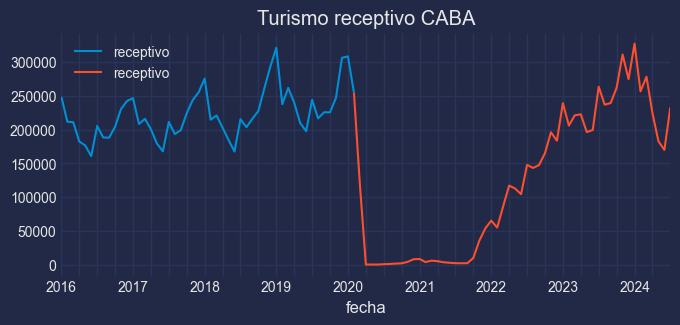

In [35]:
fecha_pandemia = '2020-02-01'
print(
    f"Fechas prepandemia : {df.index.min()} --- {df.loc[:fecha_pandemia].index.max()}  "
    f"(n={len(df.loc[:fecha_pandemia])})"
)
print(
    f"Fechas postpandemia  : {df.loc[fecha_pandemia:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[fecha_pandemia:])})"
)
pre_pandamia = df.loc[:fecha_pandemia]
post_pandamia  = df.loc[fecha_pandemia:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
pre_pandamia.plot(ax=ax, label='Receptivo pre')
post_pandamia.plot(ax=ax, label='Receptivo post')
ax.set_title('Turismo receptivo CABA')
ax.legend();

Para no hacer todo el trabajo anterior de nuevo, directamente voy a utilizar una grilla de modelos para entrenarlos y ver cuál predice mejor los datos del año 2020 para luego extraporlar el modelo a datos del 2021, 2022, 2023 y 2024

In [36]:
# Train-validation-test
# ======================================================================================
fin_train = '2018-01-01'
fin_val = '2019-01-01'
print(
    f"Fechas entrenamiento : {pre_pandamia.index.min()} --- {pre_pandamia.loc[:fin_train].index.max()}  "
    f"(n={len(pre_pandamia.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {pre_pandamia.loc[fin_train:].index.min()} --- {pre_pandamia.loc[:fin_val].index.max()}  "
    f"(n={len(pre_pandamia.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {pre_pandamia.loc[fin_val:].index.min()} --- {pre_pandamia.index.max()}  "
    f"(n={len(pre_pandamia.loc[fin_val:])})"
)


y = pre_pandamia.loc[:fin_val]

# Asegurarse de que y es una Serie
if isinstance(y, pd.DataFrame):
    y = y.squeeze()  # Convierte DataFrame de una sola columna a Series

# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1),(2, 1, 1), (2, 2, 1), (3, 2, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'c']
}

resultados_grid_MAE = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = y,
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(pre_pandamia.loc[:fin_train]),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid_MAPE = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = y,
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_percentage_error',
                        initial_train_size    = len(pre_pandamia.loc[:fin_train]),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )


Fechas entrenamiento : 2016-01-01 00:00:00 --- 2018-01-01 00:00:00  (n=25)
Fechas validacion    : 2018-01-01 00:00:00 --- 2019-01-01 00:00:00  (n=13)
Fechas test          : 2019-01-01 00:00:00 --- 2020-02-01 00:00:00  (n=14)
Number of models compared: 42.


params grid: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]


Number of models compared: 42.


params grid: 100%|██████████| 42/42 [00:12<00:00,  3.34it/s]


In [37]:
resultados_grid_MAE.head(10)

,params,mean_absolute_error,order,seasonal_order,trend
26,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",19817.551747,"(2, 1, 1)","(0, 1, 0, 12)",None
4,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",19992.890770,"(0, 1, 0)","(1, 1, 1, 12)",None
28,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20113.101131,"(2, 1, 1)","(1, 1, 1, 12)",None
32,"{'order': (2, 2, 1), 'seasonal_order': (0, 1, ...",20115.947846,"(2, 2, 1)","(0, 1, 0, 12)",None
2,"{'order': (0, 1, 0), 'seasonal_order': (0, 1, ...",20371.083333,"(0, 1, 0)","(0, 1, 0, 12)",None
14,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",20400.171760,"(1, 1, 0)","(0, 1, 0, 12)",None
8,"{'order': (0, 1, 1), 'seasonal_order': (0, 1, ...",20402.465757,"(0, 1, 1)","(0, 1, 0, 12)",None
20,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",20491.943893,"(1, 1, 1)","(0, 1, 0, 12)",None
16,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",20520.214013,"(1, 1, 0)","(1, 1, 1, 12)",None
10,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",20623.588609,"(0, 1, 1)","(1, 1, 1, 12)",None


In [38]:

resultados_grid_MAPE.head(10)

,params,mean_absolute_percentage_error,order,seasonal_order,trend
32,"{'order': (2, 2, 1), 'seasonal_order': (0, 1, ...",0.091987,"(2, 2, 1)","(0, 1, 0, 12)",None
26,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",0.092887,"(2, 1, 1)","(0, 1, 0, 12)",None
4,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",0.093546,"(0, 1, 0)","(1, 1, 1, 12)",None
28,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",0.094385,"(2, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (2, 2, 1), 'seasonal_order': (1, 1, ...",0.095210,"(2, 2, 1)","(1, 1, 1, 12)",None
2,"{'order': (0, 1, 0), 'seasonal_order': (0, 1, ...",0.095810,"(0, 1, 0)","(0, 1, 0, 12)",None
14,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",0.095960,"(1, 1, 0)","(0, 1, 0, 12)",None
8,"{'order': (0, 1, 1), 'seasonal_order': (0, 1, ...",0.095972,"(0, 1, 1)","(0, 1, 0, 12)",None
20,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",0.096443,"(1, 1, 1)","(0, 1, 0, 12)",None
16,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",0.096827,"(1, 1, 0)","(1, 1, 1, 12)",None


In [39]:
conf_int

,lower receptivo,upper receptivo
2024-08-01,1.404140e+05,2.718938e+05
2024-09-01,1.152756e+05,3.012160e+05
2024-10-01,1.167719e+05,3.445015e+05
2024-11-01,1.481399e+05,4.110993e+05
2024-12-01,9.567368e+04,3.896713e+05
...,...,...
2032-10-01,-3.567415e+06,3.253077e+06
2032-11-01,-3.571905e+06,3.350475e+06
2032-12-01,-3.661586e+06,3.361205e+06
2033-01-01,-3.661212e+06,3.460573e+06


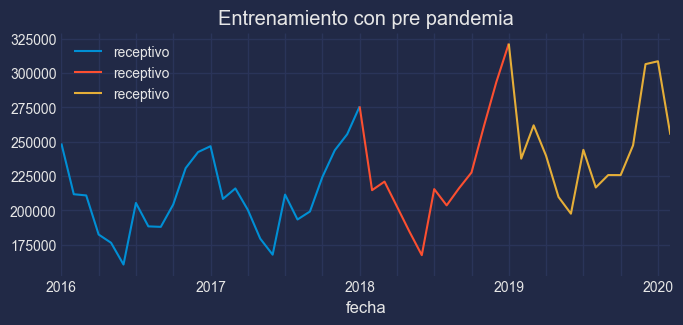

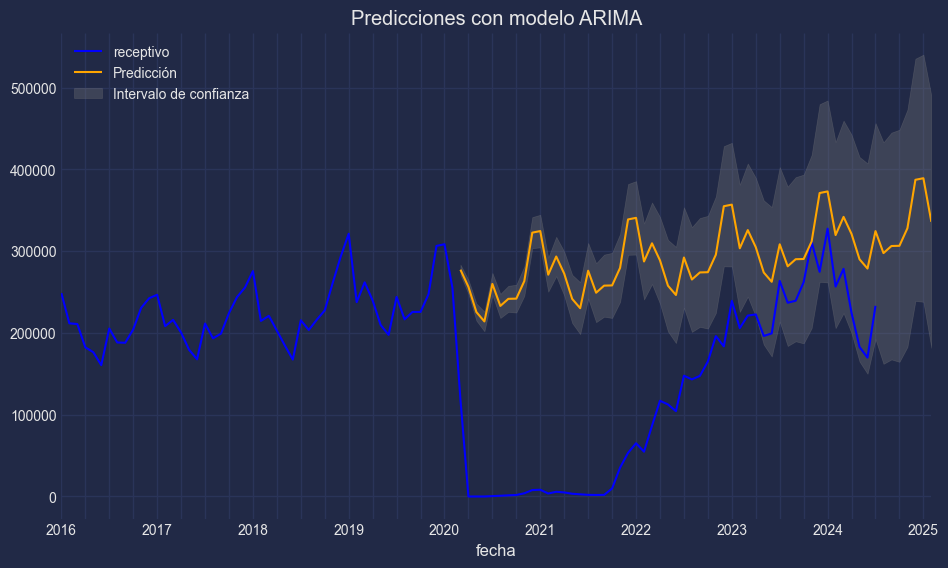

2020-03-01    277326.155708
2020-04-01    256381.618829
2020-05-01    225460.962179
2020-06-01    214070.432188
2020-07-01    259915.668937
2020-08-01    233005.912093
2020-09-01    241675.275234
2020-10-01    241933.494391
2020-11-01    263376.011653
2020-12-01    322611.890756
2021-01-01    324559.276155
2021-02-01    271204.766010
Freq: MS, Name: predicted_mean, dtype: float64

In [40]:
# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
pre_pandamia.loc[:fin_train].plot(ax=ax, label='entrenamiento')
pre_pandamia.loc[fin_train:fin_val].plot(ax=ax, label='validación')
pre_pandamia.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Entrenamiento con pre pandemia')
ax.legend();

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(pre_pandamia, order = (2, 1, 1), seasonal_order = (0, 1, 0, 12))
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=60)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha= 0.60)  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(74)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()
predicciones_df_head['predicted_mean'].head(12)

In [41]:
conf_int.round().astype(int)
predicciones_df_head.round().astype(int)

,predicted_mean,conf_int_lower,conf_int_upper,std_error
2020-03-01,277326,271176,283477,3138
2020-04-01,256382,247841,264922,4357
2020-05-01,225461,214998,235924,5338
2020-06-01,214070,202033,226108,6141
2020-07-01,259916,246455,273376,6868
2020-08-01,233006,218282,247730,7512
2020-09-01,241675,225771,257579,8114
2020-10-01,241933,224944,258923,8668
2020-11-01,263376,245356,281396,9194
2020-12-01,322612,303625,341599,9687


In [42]:
ruta_archivo = 'C:/Users/User/Desktop/Santi/Trabajo CABA/Trabajo de predicción turismo receptivo CABA/Subido/datos_ficticios.xlsx'
df_ch = pd.read_excel(ruta_archivo, sheet_name="datos_ficticios")
df_ch = df_ch.set_index('fecha')
df_ch = df_ch.asfreq('MS')
df_ch = df_ch.iloc[:-7]
df_ch = df_ch.drop(df_ch.columns[2:11], axis=1)
df_ch = df_ch.drop(df_ch.columns[0:1], axis=1)
df_ch

,receptivo
fecha,
2016-01-01,248684
2016-02-01,211731
2016-03-01,210862
2016-04-01,182419
2016-05-01,176403
...,...
2024-03-01,341888
2024-04-01,321017
2024-05-01,290038


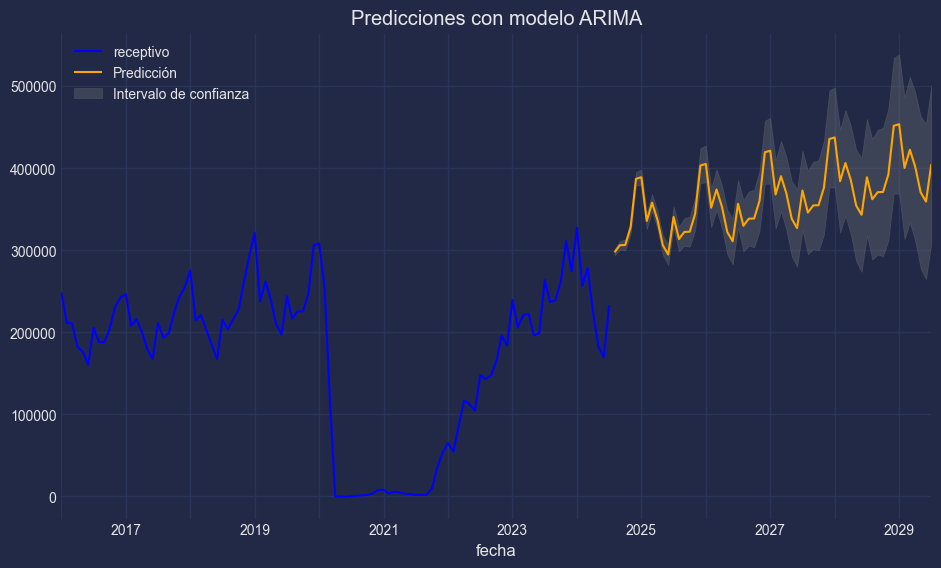

2024-08-01    297621.045703
2024-09-01    306268.009067
2024-10-01    306544.037935
2024-11-01    327973.015195
2024-12-01    387220.033108
2025-01-01    389158.018997
2025-02-01    335811.030112
2025-03-01    358039.021357
2025-04-01    337168.028254
2025-05-01    306189.022821
2025-06-01    294844.027100
2025-07-01    340654.023729
Freq: MS, Name: predicted_mean, dtype: float64

In [43]:
# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df_ch, order = (2, 1, 1), seasonal_order = (0, 1, 0, 12))
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=60)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha= 0.60)  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(74)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()
predicciones_df_head['predicted_mean'].head(12)

In [97]:
ruta_archivo = 'C:/Users/User/Desktop/Santi/Trabajo CABA/Trabajo de predicción turismo receptivo CABA/Subido/datos_ficticios.xlsx'
df_fake = pd.read_excel(ruta_archivo, sheet_name="datos_f_d")
df_fake = df_fake.set_index('fecha')
df_fake = df_fake.asfreq('MS')
df_fake = df_fake.iloc[:-49]
df_fake = df_fake.drop(df_fake.columns[4:5], axis=1)
#df_fake = df_fake.drop(df_fake.columns[2:4], axis=1)
df_fake = df_fake.drop(df_fake.columns[0:1], axis=1)
df_fake
df_fake_n = df_fake.drop(df_fake.columns[0:1], axis=1)

,predecidos
fecha,
2016-01-01,248684.0
2016-02-01,211731.0
2016-03-01,210862.0
2016-04-01,182419.0
2016-05-01,176403.0
...,...
2024-04-01,224410.0
2024-05-01,182803.0
2024-06-01,169847.0


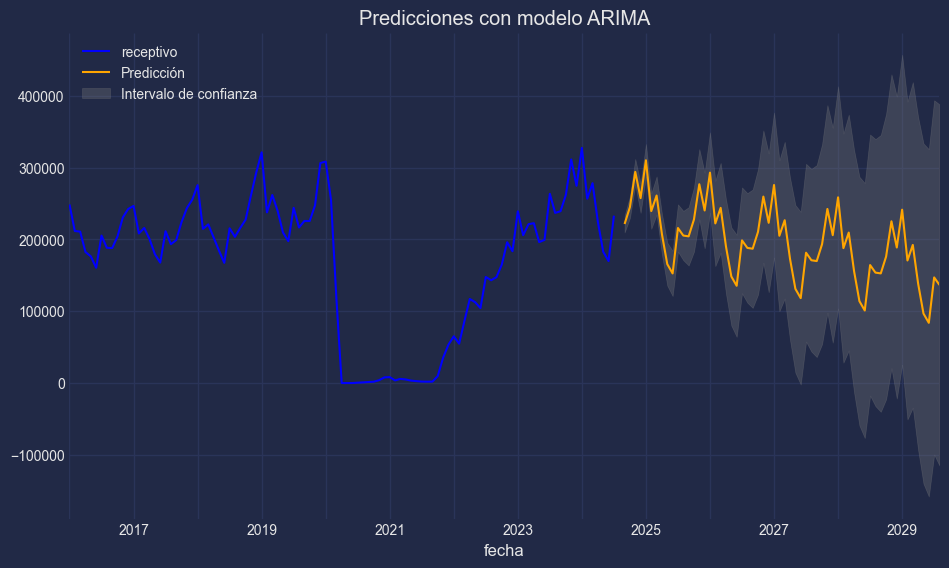

,lower predecidos,upper predecidos
2024-09-01,209619,233355
2024-10-01,229929,260049
2024-11-01,276106,312104
2024-12-01,237060,277974
2025-01-01,287559,332886
2025-02-01,214815,264155
2025-03-01,234637,287690
2025-04-01,178947,235468
2025-05-01,135706,195495
2025-06-01,121201,184088


In [107]:
# con datos promediados sin desestacionalizar entre ene-2020 y dic-2022
df_fake_n = df_fake_n.drop(df_fake_n.columns[1:2], axis=1)

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df_fake_n, order = (2, 1, 1), seasonal_order = (0, 1, 0, 12))
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=60)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha= 0.60)  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper predecidos'] - conf_int['lower predecidos']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower predecidos'],
    'conf_int_upper': conf_int['upper predecidos'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(74)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()
predicciones_df_head['predicted_mean'].head(16).round().astype(int)
conf_int.head(16).round().astype(int)

c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


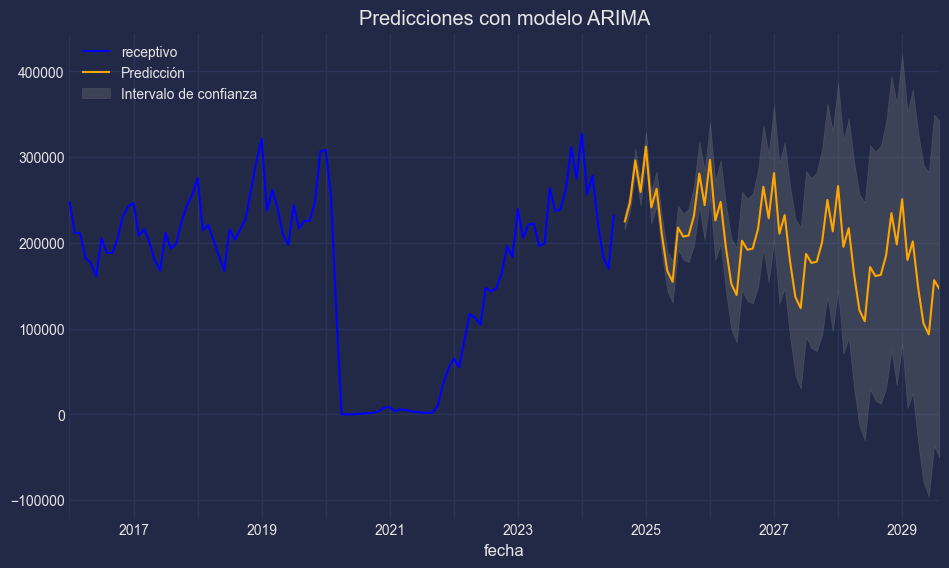

,lower predecidos_d,upper predecidos_d
2024-09-01,215360,232517
2024-10-01,235479,257958
2024-11-01,282284,309739
2024-12-01,243758,275006
2025-01-01,294653,329542
2025-02-01,222351,260365
2025-03-01,242529,283543
2025-04-01,187214,230947
2025-05-01,144302,190645
2025-06-01,130127,178908


In [106]:
# con datos promediados desestacionalizados entre ene-2020 y dic-2022
df_fake_d = df_fake.drop(df_fake.columns[0:2], axis=1)

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df_fake_d, order = (2, 1, 1), seasonal_order = (0, 1, 0, 12))
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=60)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha= 0.60)  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper predecidos_d'] - conf_int['lower predecidos_d']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower predecidos_d'],
    'conf_int_upper': conf_int['upper predecidos_d'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df_head = predicciones_df.head(74)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower'],
    predicciones_df_head['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()
predicciones_df_head['predicted_mean'].head(16).round().astype(int)

In [102]:
# Train-validation-test
# ======================================================================================
fin_train = '2023-01-01'
fin_val = '2024-01-01'
print(
    f"Fechas entrenamiento : {df_fake_d.index.min()} --- {df_fake_d.loc[:fin_train].index.max()}  "
    f"(n={len(df_fake_d.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {df_fake_d.loc[fin_train:].index.min()} --- {df_fake_d.loc[:fin_val].index.max()}  "
    f"(n={len(df_fake_d.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {df_fake_d.loc[fin_val:].index.min()} --- {df_fake_d.index.max()}  "
    f"(n={len(df_fake_d.loc[fin_val:])})"
)


y = df_fake_d.loc[:fin_val]

# Asegurarse de que y es una Serie
if isinstance(y, pd.DataFrame):
    y = y.squeeze()  # Convierte DataFrame de una sola columna a Series

# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1),(2, 1, 1), (2, 2, 1), (3, 2, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'c']
}

resultados_grid_MAE = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = y,
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(df_fake_d.loc[:fin_train]),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid_MAPE = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = y,
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_percentage_error',
                        initial_train_size    = len(df_fake_d.loc[:fin_train]),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )


Fechas entrenamiento : 2016-01-01 00:00:00 --- 2023-01-01 00:00:00  (n=85)
Fechas validacion    : 2023-01-01 00:00:00 --- 2024-01-01 00:00:00  (n=13)
Fechas test          : 2024-01-01 00:00:00 --- 2024-08-01 00:00:00  (n=8)
Number of models compared: 42.


params grid: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]


Number of models compared: 42.


params grid: 100%|██████████| 42/42 [00:12<00:00,  3.44it/s]


In [92]:
conf_int.round().astype(int)

,lower predecidos_d,upper predecidos_d
2024-09-01,215360,232517
2024-10-01,235479,257958
2024-11-01,282284,309739
2024-12-01,243758,275006
2025-01-01,294653,329542
2025-02-01,222351,260365
2025-03-01,242529,283543
2025-04-01,187214,230947
2025-05-01,144302,190645
2025-06-01,130127,178908


              Real       Ajustado
fecha                            
2016-01-01  248684       0.000000
2016-02-01  211731  290890.447607
2016-03-01  210862  195700.712643
2016-04-01  182419  208846.385357
2016-05-01  176403  176825.978102
2016-06-01  160586  176176.338579
2016-07-01  205385  158302.046751
2016-08-01  188354  214000.833667
2016-09-01  187990  183986.213142
2016-10-01  204246  188081.033975
2016-11-01  230713  207169.704854
2016-12-01  242419  234800.033371
2017-01-01  246675  491777.528592
2017-02-01  208332  165978.599803
              Real       Ajustado
fecha                            
2024-06-01  169847  185349.366184
2024-07-01  233105  232406.265342


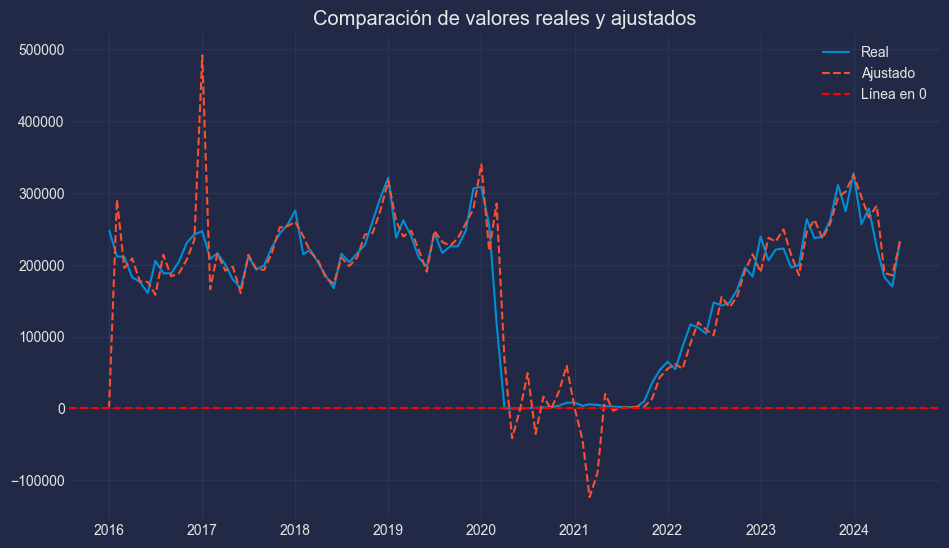

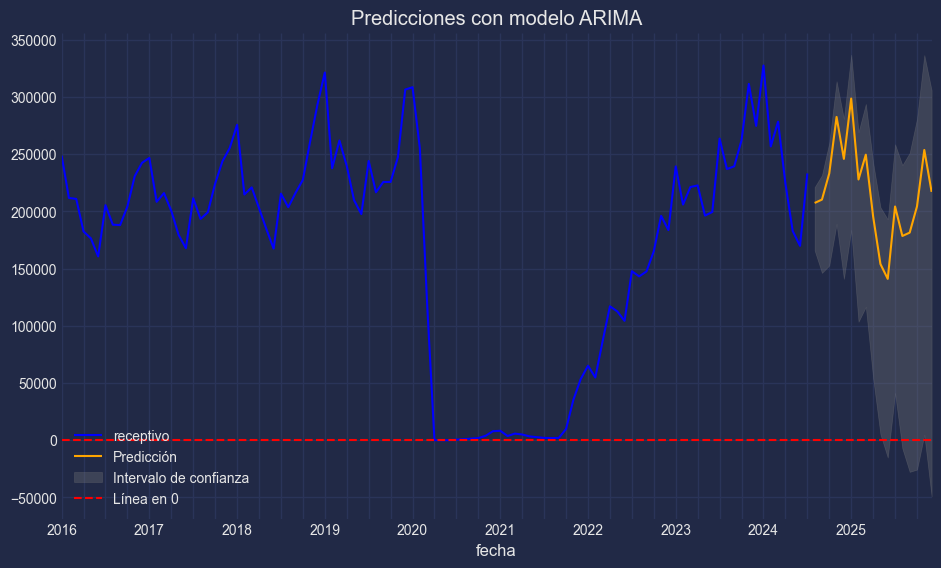

2024-08-01    207320.051921
2024-09-01    210246.269358
2024-10-01    233137.229187
2024-11-01    282480.912722
2024-12-01    245855.233168
2025-01-01    298569.696744
2025-02-01    227828.404448
2025-03-01    249506.890130
2025-04-01    195550.750291
2025-05-01    153943.727792
2025-06-01    140987.729611
2025-07-01    204245.732684
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (2, 1, 1), seasonal_order = (0, 1, 0, 12))
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.40)  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
})


import matplotlib.pyplot as plt

# Observo el ajuste dentro de los datos

fitted_values = results.fittedvalues
# Crear un DataFrame que compare los valores reales y ajustados
comparison_1 = pd.DataFrame({'Real': df['receptivo'], 'Ajustado': fitted_values})



# Mostrar los primeros valores para verificar
print(comparison_1.head(14))
print(comparison_1.tail(2))

# Graficar valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(comparison_1.index, comparison_1['Real'], label='Real')
plt.plot(comparison_1.index, fitted_values, label='Ajustado', linestyle='--')
# Añadir línea en y=0
plt.axhline(y=0, color='red', linestyle='--', label='Línea en 0')
plt.title('Comparación de valores reales y ajustados')
plt.legend()
plt.show()

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df['diff_up_mean'] = (predicciones_df['conf_int_upper'] - predicciones_df['predicted_mean'])/2
predicciones_df['new_conf_int_upper'] = predicciones_df['conf_int_upper'] - predicciones_df['diff_up_mean']
predicciones_df['new_conf_int_lower'] = predicciones_df['conf_int_lower'] - predicciones_df['diff_up_mean']

predicciones_df_head = predicciones_df.head(17)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['new_conf_int_lower'],
    predicciones_df_head['new_conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)
# Añadir línea en y=0
plt.axhline(y=0, color='red', linestyle='--', label='Línea en 0')

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()

predicciones_df_head['predicted_mean'].head(12)


In [47]:
archivo_excel = 'predicciones_df_head.xlsx'

# Exporta el DataFrame a un archivo Excel
predicciones_df_head.to_excel(archivo_excel, index=True, engine='openpyxl')

In [48]:
import pandas as pd
import numpy as np

# Filtro
mask = comparison_1['Real'] != 0
filtered_comparison_1 = comparison_1[mask].copy()

# Calcular MAE
MAEm2 = abs(filtered_comparison_1['Ajustado'] - filtered_comparison_1['Real']).mean()
print(MAEm2)

# Calcular MAPE
MAPEm2 = (abs((filtered_comparison_1['Real'] - filtered_comparison_1['Ajustado']) / filtered_comparison_1['Real'])).mean()
print(MAPEm2)


24483.405170453014
2.374187006901763


In [49]:
archivo_excel = 'comparison_1.xlsx'

# Exporta el DataFrame a un archivo Excel
comparison_1.to_excel(archivo_excel, index=False, engine='openpyxl')

#### Modelo final con intervalos de confianza constantes

              Real       Ajustado
fecha                            
2016-01-01  248684       0.000000
2016-02-01  211731  290890.447607
2016-03-01  210862  195700.712643
2016-04-01  182419  208846.385357
2016-05-01  176403  176825.978102
2016-06-01  160586  176176.338579
2016-07-01  205385  158302.046751
2016-08-01  188354  214000.833667
2016-09-01  187990  183986.213142
2016-10-01  204246  188081.033975
2016-11-01  230713  207169.704854
2016-12-01  242419  234800.033371
2017-01-01  246675  491777.528592
2017-02-01  208332  165978.599803
              Real       Ajustado
fecha                            
2024-06-01  169847  185349.366184
2024-07-01  233105  232406.265342


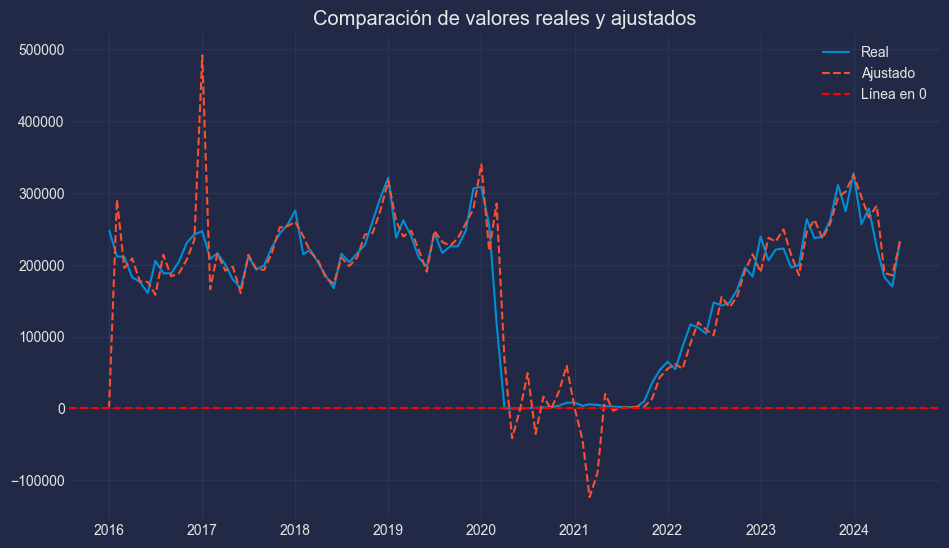

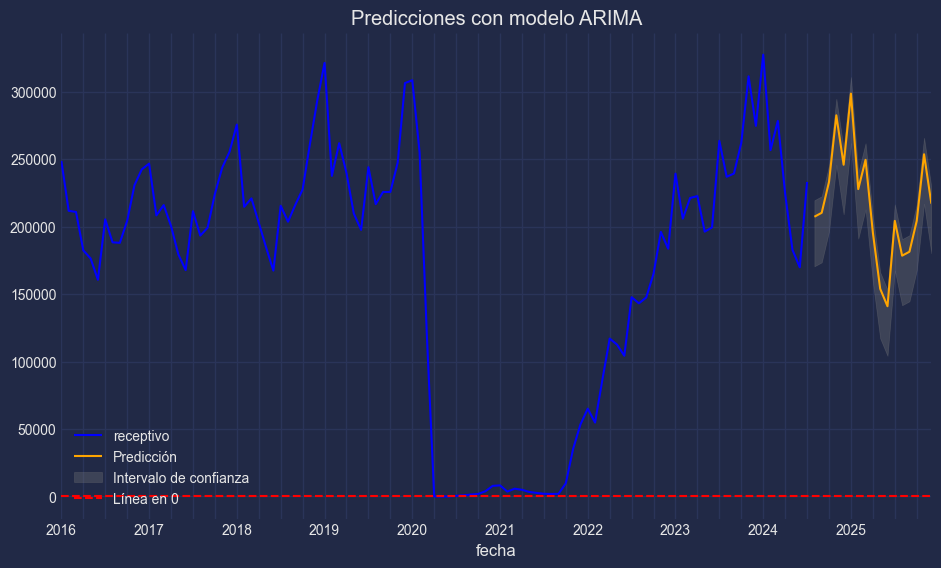

2024-08-01    207320.051921
2024-09-01    210246.269358
2024-10-01    233137.229187
2024-11-01    282480.912722
2024-12-01    245855.233168
2025-01-01    298569.696744
2025-02-01    227828.404448
2025-03-01    249506.890130
2025-04-01    195550.750291
2025-05-01    153943.727792
2025-06-01    140987.729611
2025-07-01    204245.732684
Freq: MS, Name: predicted_mean, dtype: float64

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Ajustar el modelo SARIMAX directamente con statsmodels
model = SARIMAX(df, order = (2, 1, 1), seasonal_order = (0, 1, 0, 12))
results = model.fit()

# Realizar predicciones
forecast = results.get_forecast(steps=len(df))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.40)  # Obtiene intervalos de confianza	

# Extraer el error estándar de las predicciones
# El intervalo de confianza proporciona los errores estándar indirectamente
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Convertir los resultados a un DataFrame
predicciones_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'MAE': MAEm2,
    'std_error': std_errors
})
predicciones_df['conf_int_lower_cte'] = predicciones_df['predicted_mean'] - MAEm2 - MAEm2/2
predicciones_df['conf_int_upper_cte'] = predicciones_df['predicted_mean'] + MAEm2/2


import matplotlib.pyplot as plt

# Observo el ajuste dentro de los datos

fitted_values = results.fittedvalues
# Crear un DataFrame que compare los valores reales y ajustados
comparison_1 = pd.DataFrame({'Real': df['receptivo'], 'Ajustado': fitted_values})



# Mostrar los primeros valores para verificar
print(comparison_1.head(14))
print(comparison_1.tail(2))

# Graficar valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(comparison_1.index, comparison_1['Real'], label='Real')
plt.plot(comparison_1.index, fitted_values, label='Ajustado', linestyle='--')
# Añadir línea en y=0
plt.axhline(y=0, color='red', linestyle='--', label='Línea en 0')
plt.title('Comparación de valores reales y ajustados')
plt.legend()
plt.show()

# Graficar predicciones
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar datos originales
df.plot(ax=ax, label='Turismo Receptivo', color='blue')

predicciones_df['diff_up_mean'] = (predicciones_df['conf_int_upper'] - predicciones_df['predicted_mean'])/2
predicciones_df['new_conf_int_upper'] = predicciones_df['conf_int_upper'] - predicciones_df['diff_up_mean']
predicciones_df['new_conf_int_lower'] = predicciones_df['conf_int_lower'] - predicciones_df['diff_up_mean']

predicciones_df_head = predicciones_df.head(17)

# Graficar predicciones
predicciones_df_head['predicted_mean'].plot(ax=ax, label='Predicción', color='orange')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df_head.index,
    predicciones_df_head['conf_int_lower_cte'],
    predicciones_df_head['conf_int_upper_cte'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)
# Añadir línea en y=0
plt.axhline(y=0, color='red', linestyle='--', label='Línea en 0')

# Añadir títulos y etiquetas
ax.set_title('Predicciones con modelo ARIMA')
ax.legend()

plt.show()

predicciones_df_head['predicted_mean'].head(12)


In [51]:
archivo_excel = 'predicciones_df_cte.xlsx'

# Exporta el DataFrame a un archivo Excel
predicciones_df_head.to_excel(archivo_excel, index=True, engine='openpyxl')

#### MODELO ETS

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.api as sm

# Suponiendo que df es tu DataFrame con la columna 'receptivo'
# Filtrar las filas donde 'receptivo' es cero y reemplazar ceros con unos
df_without_zeros = pd.DataFrame(df['receptivo'])
df_without_zeros['receptivo'] = df['receptivo'].replace(0, 1)

# Ajustar el modelo ETS
model = ETSModel(
    df_without_zeros['receptivo'],
    error="add",
    trend="mul",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=12
)

fitted_model = model.fit(smoothing_level=0.99, smoothing_trend=0.5, smoothing_seasonal=0, damping_trend=0)
fitted_values = fitted_model.fittedvalues

# Realizar predicciones futuras
forecast_length = 12  # Ajusta según tus necesidades
predictions = fitted_model.forecast(steps=forecast_length)

conf_int = fitted_model.conf_int(alpha=0.05)
conf_int = conf_int.rename(columns={"0": "lower receptivo", "1": "upper receptivo"})

# Extraer el error estándar de las predicciones
std_errors = (conf_int['upper receptivo'] - conf_int['lower receptivo']) / (2 * 1.96)

# Crear DataFrame para valores ajustados y predicciones
df_ajustados = pd.DataFrame({
    'Real': df['receptivo'],
    'Ajustado': fitted_values
})

predicciones_df = pd.DataFrame({
    'predicted_mean': predictions,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo'],
    'std_error': std_errors
}, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_length, freq='M'))

# Calcular MAE y MAPE
mask = df_ajustados['Real'] != 0
df_ajustados_2 = df_ajustados[mask]

MAEm2 = abs(df_ajustados_2['Ajustado'] - df_ajustados_2['Real']).mean()
MAPEm2 = (abs((df_ajustados_2['Real'] - df_ajustados_2['Ajustado']) / df_ajustados_2['Real'])).mean()

print("MAE:", MAEm2)
print("MAPE:", MAPEm2)

# Graficar datos originales, valores ajustados y predicciones
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar datos originales
df['receptivo'].plot(ax=ax, label='Datos originales', color='blue')

# Graficar valores ajustados
fitted_values.plot(ax=ax, label='Valores ajustados', linestyle='--', color='orange')

# Graficar predicciones
predicciones_df['predicted_mean'].plot(ax=ax, label='Predicciones', linestyle='--', color='red')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df.index,
    predicciones_df['conf_int_lower'],
    predicciones_df['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Datos originales, valores ajustados y predicciones con intervalos de confianza')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
plt.show()


c:\Python\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: smoothing_level, smoothing_seasonal, damping_trend, smoothing_trend. After release 0.14, this will raise.
  warnings.warn(


KeyError: 'upper receptivo'

In [51]:
conf_int.rename(columns={"0": "lower receptivo", "1": "upper receptivo"})
conf_int

,0,1
0,NaN,NaN
1,-0.000021,0.000221
2,NaN,NaN
3,202742.283327,202742.283339
4,0.958559,1.013939
5,0.693391,1.115775
6,0.659036,1.077742
7,0.570979,0.947790
8,0.524887,0.884776
9,0.505831,0.863589


c:\Python\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: smoothing_seasonal, smoothing_level, damping_trend, smoothing_trend. After release 0.14, this will raise.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_5332\33296439.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  }, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_length, freq='M'))


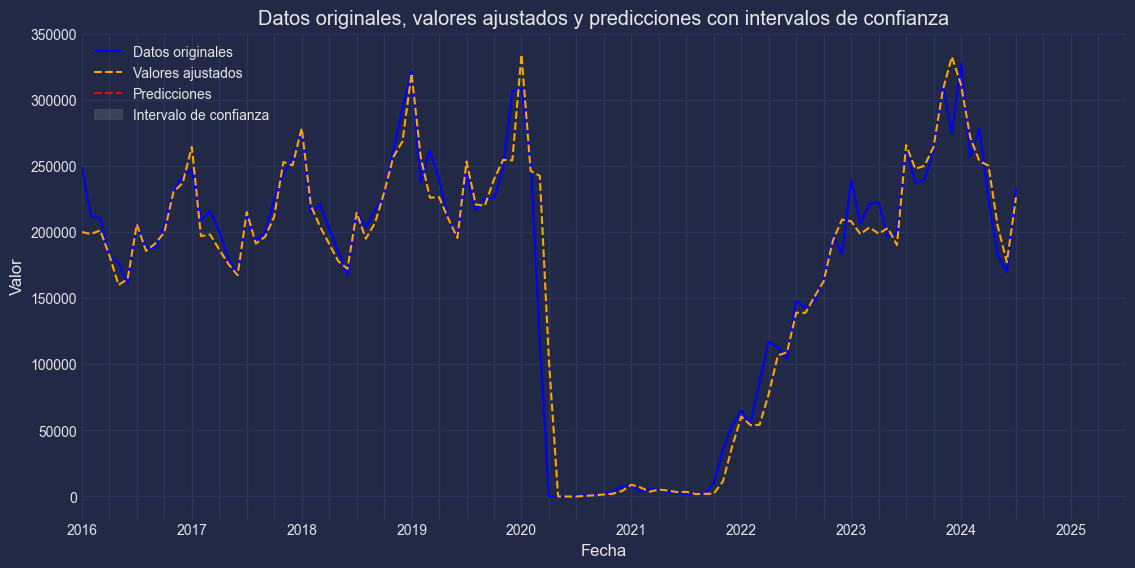

MAE: 11307.925929009873
MAPE: 0.12983944358118948


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Crear un DataFrame de ejemplo

# Filtrar las filas donde 'receptivo' es cero
df_without_zeros = pd.DataFrame(df['receptivo'])
df_without_zeros['receptivo'] = df['receptivo'].replace(0, 1)

# Ajustar el modelo ETS
model = ETSModel(
    df_without_zeros['receptivo'],
    error="add",
    trend="mul",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=12
)

fitted_model = model.fit(smoothing_level=0.99, smoothing_trend=0.5, smoothing_seasonal=0, damping_trend=0)
fitted_values = fitted_model.fittedvalues

# Realizar predicciones futuras
forecast_length = 12
predictions = fitted_model.forecast(steps=forecast_length)

# Intervalos de confianza
conf_int = forecast.conf_int(alpha=0.05)

# Preparar datos para graficar
df_ajustados = pd.DataFrame({
    'Real': df['receptivo'],
    'Ajustado': fitted_values
})

predicciones_df = pd.DataFrame({
    'predicted_mean': predictions,
    'conf_int_lower': conf_int['lower receptivo'],
    'conf_int_upper': conf_int['upper receptivo']
}, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_length, freq='M'))

# Graficar
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar datos originales
df['receptivo'].plot(ax=ax, label='Datos originales', color='blue')

# Graficar valores ajustados
fitted_values.plot(ax=ax, label='Valores ajustados', linestyle='--', color='orange')

# Graficar predicciones
predicciones_df['predicted_mean'].plot(ax=ax, label='Predicciones', linestyle='--', color='red')

# Graficar intervalos de confianza
ax.fill_between(
    predicciones_df.index,
    predicciones_df['conf_int_lower'],
    predicciones_df['conf_int_upper'],
    color='gray', alpha=0.3, label='Intervalo de confianza'
)

# Añadir títulos y etiquetas
ax.set_title('Datos originales, valores ajustados y predicciones con intervalos de confianza')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
plt.show()

# Calcular MAE y MAPE
mask = df_ajustados['Real'] != 0
df_ajustados_2 = df_ajustados[mask]

MAEm2 = abs(df_ajustados_2['Ajustado'] - df_ajustados_2['Real']).mean()
MAPEm2 = (abs((df_ajustados_2['Real'] - df_ajustados_2['Ajustado']) / df_ajustados_2['Real'])).mean()

print("MAE:", MAEm2)
print("MAPE:", MAPEm2)


In [45]:
conf_int

,lower receptivo,upper receptivo
2024-08-01,1.428994e+05,2.717407e+05
2024-09-01,1.108013e+05,3.096912e+05
2024-10-01,1.083289e+05,3.579455e+05
2024-11-01,1.373005e+05,4.276613e+05
2024-12-01,8.310494e+04,4.086055e+05
...,...,...
2032-10-01,-3.798568e+06,3.803094e+06
2032-11-01,-3.806234e+06,3.909447e+06
2032-12-01,-3.898936e+06,3.928898e+06
2033-01-01,-3.901474e+06,4.036865e+06
